## Time series forecasting with TensorFlow + Milestone Project 3: BitPredict

Let's write some code to predict the price of Bitcoin based on the historical price of Bitcoin

## Get data

In [1]:
# !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv


## Importing time series with pandas

In [2]:
import pandas as pd
df = pd.read_csv("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
parse_dates=["Date"],
index_col=["Date"]) # pass the data column and tell pandas column 1 is a datetime
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [4]:
# How many samples we have
len(df)

2787

We have collected the historical price of Bitcoin for the past ~8 years, but there's 2787 samples

Typically deep learning models usually like lots and lots of samples

A smaller number of samples is something we'll often run with time series data problem

> **Note:** The **seasonality** of a time series dataset is referred as the number as the number of samples per year. So for our Bitcoin data, it has a seasonality of daily or value of 365 because we collect one sample per day meaning we'll get 365 samples per year

In [5]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


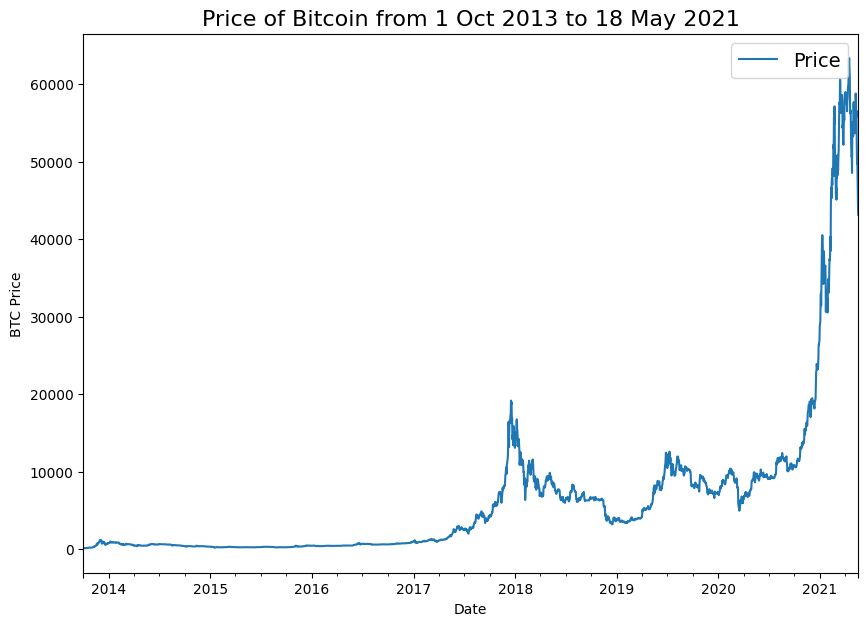

In [6]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

## Importing time series data with Python's CSV module


In [7]:
# Importing and formatting historical Bitcoin data with Python
import csv
from datetime import datetime

timesteps = []
btc_price = []
with open("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
    csv_reader = csv.reader(f, delimiter=",")
    next(csv_reader) # skip first line (this gets rid of the column titles)
    for line in csv_reader:
        timesteps.append(datetime.strptime(line[1], "%Y-%m-%d"))    # get the dates as dates (not strings)
        btc_price.append(float(line[2]))    # get closing price as float

# view first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

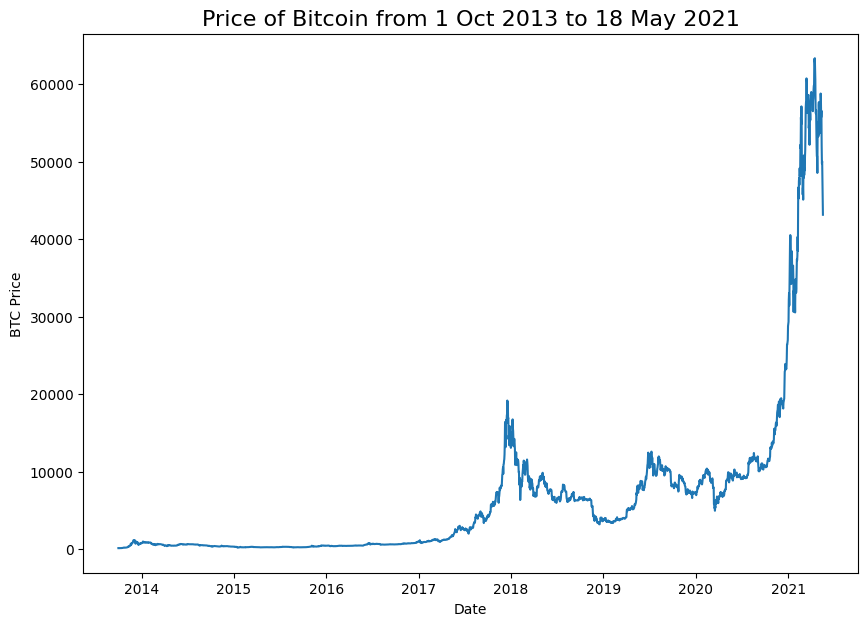

In [8]:
# Plot from CSV
import numpy as np
plt.figure(figsize=(10, 7))
plt.plot(timesteps, btc_price)
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.xlabel("Date");

## Format data part 1; Create train and test sets of our time series data

### Creating train and test series with time series data (the wrong way)

In [9]:
# Get bitcoin data array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [10]:
# Wrong way to make train/test sets for time series data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(timesteps,
                                                    prices,
                                                    test_size=0.2,
                                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

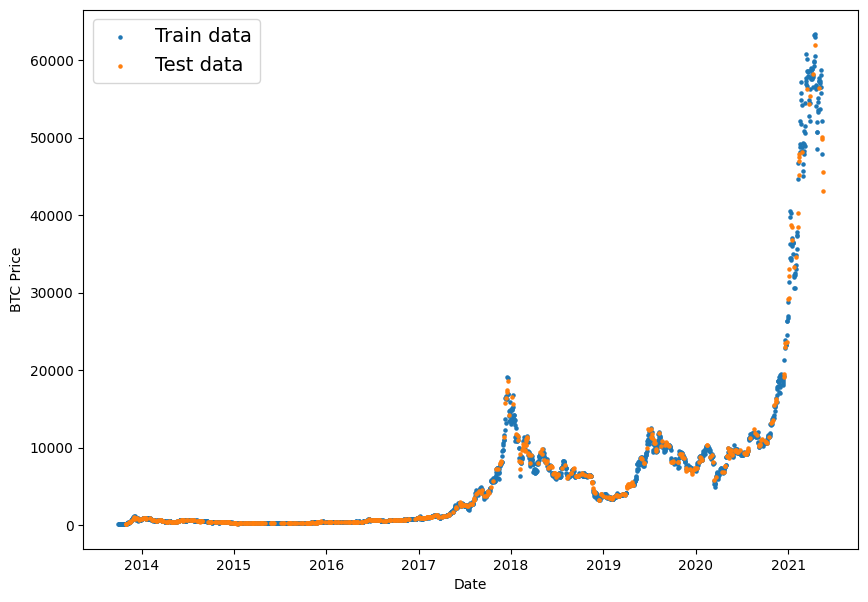

In [11]:
# Lets plot wring train and test splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

### Create train and test sets for time series

In [12]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) #80% train, 20% test - we can change these values as needed

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything beyond the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

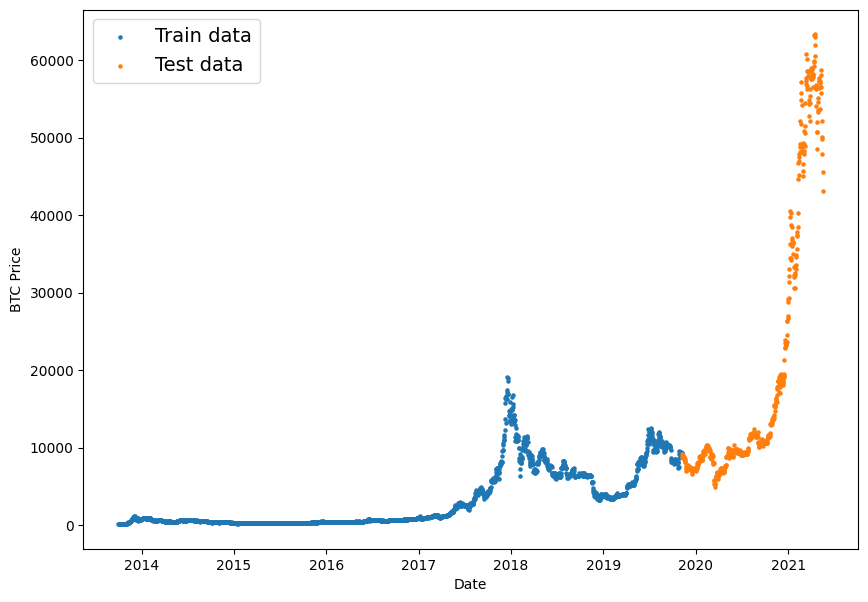

In [13]:
# plot corrently made splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

## Create a plotting function

In [14]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
    """
    Plots timesteps (a series of points in time) against values (a series of values across timesteps).

    Parameters
    ----------
    timesteps : array of timestep values
    values : array of values across time
    format : style of plot, default "."
    start : where to start the plot (setting a value will index from start of timesteps & values)
    end : where to end the plot (similar to start but for the end)
    label : label to show on plot about values, default None
    """
    
    # plot series
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("BTC Prices")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)


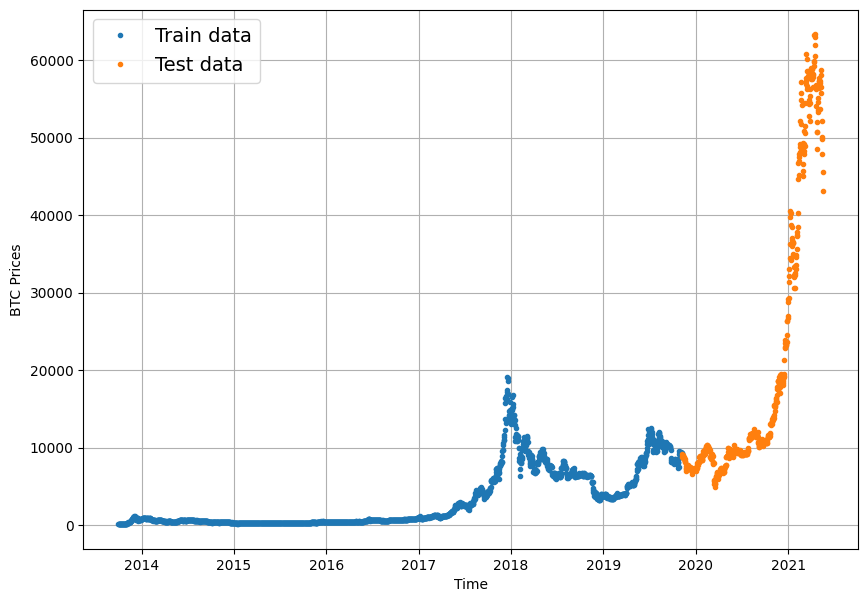

In [15]:
# Test our plotting func
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

## Modelling Experiments

We got some Bitcoin historical data to model it. We will run a series of modelling experiments to see which model runs the best

Terms to be familiar with:
* **Horizon** = number of timesteps into the future we're going to predict
* **Windows size** = number of timesteps we're going to use to predict **horizon**


| Model Number | Model Type | Horizon size | Window size | Extra data |
|--------------|------------|--------------|-------------|------------|
| 0 | Naïve model (baseline) | NA | NA | NA |
| 1 | Dense model | 1 | 7 | NA |
| 2 | Same as 1 | 1 | 30 | NA |
| 3 | Same as 1 | 7 | 30 | NA |
| 4 | Conv1D | 1 | 7 | NA |
| 5 | LSTM | 1 | 7 | NA |
| 6 | Same as 1 (but with multivariate data) | 1 | 7 | Block reward size |
| 7 | N-BEATs Algorithm | 1 | 7 | NA |
| 8 | Ensemble (multiple models optimized on different loss functions) | 1 | 7 | NA |
| 9 | Future prediction model (model to predict future values) | 1 | 7 | NA |
| 10 | Same as 1 (but with turkey 🦃 data introduced) | 1 | 7 | NA |



## Model 0: Naive forecast (baseline)


In [16]:
# Create a naive forecast
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

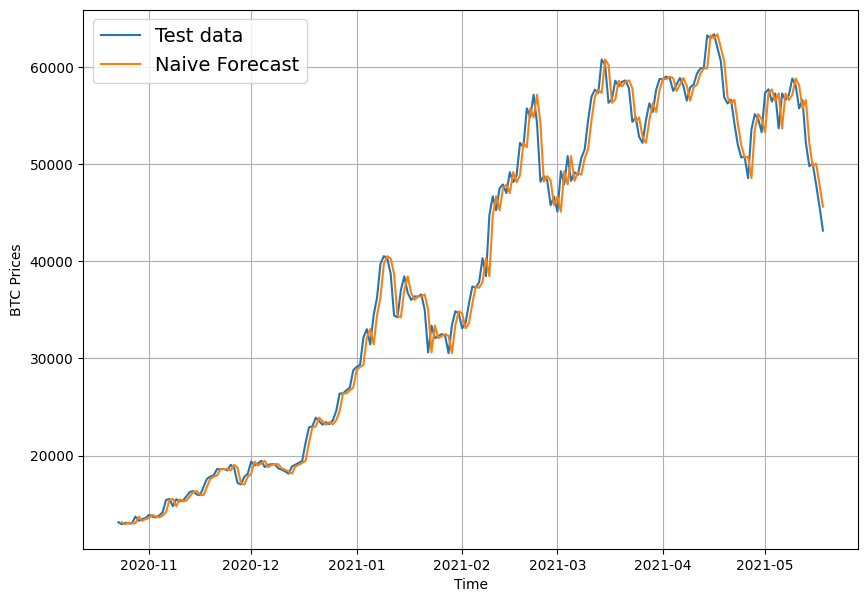

In [17]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
# plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, start=350, format="-", label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start=350, format="-", label="Naive Forecast")

## Evaluating a time series model

Let's look into some evaluation metrics for time series forecasting.

What are we doing?

We're predicting a number, so that means we have a form of a regression problems.

Because we're working on a regression problems, we'll need some regression-like metrics.

A few common regressin matrics (which can we also be used for time series forecasting):
* MAE - mean absolute error
* MSE - mean squared error
* RMSE - root mean squared  error
* MAPE/sMAPE - (symmetric) mean absolute percentage error
* MASE - mean absolute scaled error

For all above metrics, **lower is better**

The main thing we're evaluating here is: **how do our models forecasts (y_pred) compare against the actual values (y_true or ground truth values)?**

In [18]:
import tensorflow as tf


In [19]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
    """
    Implement MASE (assuming no seasonility of data)
    """
    mae = tf.reduce_mean(tf.abs(y_true-y_pred))

    # FInd MAE of naive forecast (no seasonality)
    mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))  # our seasonality is 1 day (hence the shift of 1)

    return mae/mae_naive_no_season

In [20]:
mean_absolute_scaled_error(y_true=y_test[1:], y_pred=naive_forecast).numpy()


0.9995699939182624

In [21]:
# Create a function to take in model predictions and truth values and return evaluate metrics
def evaluate_preds(y_true, y_pred):
    # Make sure float32 datatype (for metric calculations)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Calculate various evaluation metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)

    return {"mae": mae.numpy(),
            "mse": mse.numpy(),
            "rmse": rmse.numpy(),
            "mape": mape.numpy(),
            "mase": mase.numpy()}

In [22]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

In [23]:
tf.reduce_mean(y_test)

<tf.Tensor: shape=(), dtype=float64, numpy=20056.632963737222>

## Format Data Part 2: Windowing our dataset

Why do we window?

We window our time series dataset to turn our data into a supervised learning problem.

```
Windowing for one week
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [24]:
len(y_train)

2229

In [25]:
btc_price[:8]

[123.65499,
 125.455,
 108.58483,
 118.67466,
 121.33866,
 120.65533,
 121.795,
 123.033]

In [26]:
# What we want to do with our Bitcoin data
print(f"We want to use {btc_price[:7]} to predict this: {btc_price[7]}")

We want to use [123.65499, 125.455, 108.58483, 118.67466, 121.33866, 120.65533, 121.795] to predict this: 123.033


In [27]:
# Let's setup global variables for window and horizon size
HORIZON = 1     # predict next 1 day
WINDOW_SIZE = 7    # Use the past week of Bitcoin data to make the prediction

In [28]:
# Create function to label windowed data
def get_labelled_windows(x ,horizon=HORIZON):
    '''
    Create labels for windowed dataset.

    E.g. if horizon = 1
    Input: [0, 1, 2, 3, 4, 5, 6, 7] -> Output: ([0, 1, 2, 3, 4, 5, 6], [7])
    '''
    return x[:, :-horizon], x[:, -horizon:]

In [29]:
# Test out the windows labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8), axis=0))
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [0 1 2 3 4 5 6] -> Label: 7


We've got a way to label our windowed data

However, this only works on a small scale.

We need a way to do the above across our entire time series.

We can do this with python for loops, but for large time series it will be too slow. So we will use NumPy's array indexing to speed things up

Our function will:
1. Create a window step of specific window size (eg. [0, 1, 2, 3, 4, 5, 6])
2. Use NumPy indexing to create a 2D array of multiple window steps, eg:

```
[[0, 1, 2, 3, 4, 5, 6],
[1, 2, 3, 4, 5, 6, 7],
[2, 3, 4, 5, 6, 7, 8]]
```
3. Use the 2D array of multiple window steps (from 2.) to index on a target series (eg. the historical price of Bitcoin)
4. Uses our `get_labelled_windows()` function we create above to turn the window steps into windows with a speficied horizon

In [30]:
import numpy as np

# Create function to view NumPy arrays as windows
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
    """
    Turns a 1D array into a 2D array of sequential labelled windows of window_size with horizon size labels.
    """
    # 1. Create a window of specific window_size (add the horizon on the end for labelling later)
    window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

    # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
    window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T  # create 2D array of windows of size window_size

    # 3. Index on  the target array (a time series) with 2D array of multiple window steps
    windowed_array = x[window_indexes]

    # 4. Get the labelled windows
    windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

    return windows, labels

In [31]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [32]:
# View the first 3 windows/labels
for i in range(3):
    print(f"Window: {full_windows[i]} -> label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> label: [125.96116]


In [33]:
# View last 3 windows/labels
for i in range(3):
    print(f"Window: {full_windows[i-3]} -> Label:{full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label:[47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label:[45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label:[43144.47129086]


## Turning windows into training and test sets

In [34]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
    """
    Splits matching pairs of windows and labels into train and test splits.
    """
    split_size = int(len(windows) * (1-test_split))     # this willl default to 80% train/20% test
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]

    return train_windows, test_windows, train_labels, test_labels


In [35]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [36]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [37]:
test_windows[:5], test_labels[:5]

(array([[9290.89660239, 9202.41545055, 9369.62808116, 9326.59962378,
         9335.75240233, 9226.48582088, 8794.35864452],
        [9202.41545055, 9369.62808116, 9326.59962378, 9335.75240233,
         9226.48582088, 8794.35864452, 8798.04205463],
        [9369.62808116, 9326.59962378, 9335.75240233, 9226.48582088,
         8794.35864452, 8798.04205463, 9081.18687849],
        [9326.59962378, 9335.75240233, 9226.48582088, 8794.35864452,
         8798.04205463, 9081.18687849, 8711.53433917],
        [9335.75240233, 9226.48582088, 8794.35864452, 8798.04205463,
         9081.18687849, 8711.53433917, 8760.89271814]]),
 array([[8798.04205463],
        [9081.18687849],
        [8711.53433917],
        [8760.89271814],
        [8749.52059102]]))

In [38]:
# Check to see if train labels are the same (before and after window split)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

## Make a modelling checkpoint

Because our model's performance will fluctuate from experiment to experiment, we're going to write a model checkpoint so we can compare apples to apples.

More specifically, we want to compare each of our model's best performance against the other model's best performances.

For example, if our model performs the best on epoch 55 (but we're training for 100 epochs), we want to load and evaluate the model saved on epoch 55

In [39]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                              monitor="val_loss",
                                              verbose=0,    # Only output a limited amound of text
                                              save_best_only=True)

## Model 1: Dense model (window = 7, horizon = 1)

Our model deep model is going to be a simple dense model:
* A single dense layer with 1228 hidden units and ReLU
* An output layer with linear activation (no activation)
* Adam optimizer and MAE loss function 
* Batch size of 128 (previously we've used 32)
* 100 epochs

In [40]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# 1. Construct model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear")
], name="model_1_dense")

# 2. Compile
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae", "mse"])

# 3. Fit the model
model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])


Epoch 1/100
18/18 [==============================] - 4s 88ms/step - loss: 1309.0443 - mae: 1309.0443 - mse: 6184416.5000 - val_loss: 3125.1052 - val_mae: 3125.1052 - val_mse: 21033056.0000
Epoch 2/100
18/18 [==============================] - 1s 48ms/step - loss: 337.9140 - mae: 337.9140 - mse: 465362.2188 - val_loss: 1142.2972 - val_mae: 1142.2972 - val_mse: 3604555.7500
Epoch 3/100
18/18 [==============================] - 1s 47ms/step - loss: 184.7764 - mae: 184.7764 - mse: 168615.4531 - val_loss: 969.9858 - val_mae: 969.9858 - val_mse: 2957996.7500
Epoch 4/100
18/18 [==============================] - 1s 47ms/step - loss: 172.4286 - mae: 172.4286 - mse: 158194.6406 - val_loss: 912.7345 - val_mae: 912.7345 - val_mse: 2845558.7500
Epoch 5/100
18/18 [==============================] - 0s 9ms/step - loss: 163.9323 - mae: 163.9323 - mse: 146269.0938 - val_loss: 933.2062 - val_mae: 933.2062 - val_mse: 2739752.0000
Epoch 6/100
18/18 [==============================] - 1s 47ms/step - loss: 161.

In [41]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 5ms/step - loss: 670.8511 - mae: 670.8511 - mse: 1382650.7500


[670.8511352539062, 670.8511352539062, 1382650.75]

In [42]:
# Load in saved best performing model_1 and evaluate it on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense/")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 568.0982 - mae: 568.0982 - mse: 1167905.7500


[568.0982055664062, 568.0982055664062, 1167905.75]

## Making forecast with a model (on test dataset)

To make forecast on the test dataset (note: these won't be actual forecast, they're only pseudo forecasts because actual forecasts are into the future), we will write a function to:
1. Take in a train model.
2. Takes in some input data (same kind of data the model was trained on)
3. Passes the input data to the model's `predict()` method
4. Returns the predictions

In [43]:
def make_preds(model, input_data):
    """
    Uses model to make predictions input_data
    """
    forecast = model.predict(input_data)
    return tf.squeeze(forecast) # return 1D array of predictions

In [44]:
# Make predictions using model_1 in the test dataset and view results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 [==============================] - 0s 3ms/step


(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8868.128 , 8772.5625, 9037.938 , 8788.449 , 8727.553 , 8765.652 ,
        8680.974 , 8528.307 , 8465.72  , 8532.788 ], dtype=float32)>)

In [45]:
tf.squeeze(test_labels).shape, model_1_preds.shape

(TensorShape([556]), TensorShape([556]))

In [46]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_1_preds)
model_1_results

{'mae': 568.09814,
 'mse': 1167905.6,
 'rmse': 1080.6968,
 'mape': 2.541746,
 'mase': 0.9979911}

In [47]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

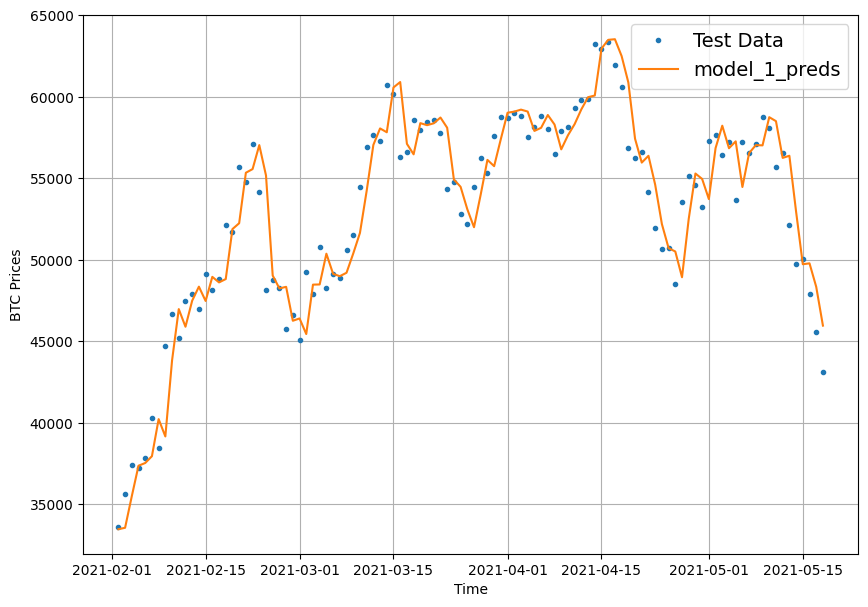

In [48]:
# Let's plot our model predictions
offset = 450
plt.figure(figsize=(10, 7))

# Account for the test_windows offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 start=offset, 
                 label="Test Data")

plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=model_1_preds,
                 start=offset,
                 format="-",
                 label="model_1_preds")

## Model 2: Dense(windows = 30, horizon = 1)

In [49]:
HORIZON = 1     # predict one step at a time (one day of Bitcoin prices)
WINDOW_SIZE = 30     # Use 30 timesteps in the past

In [50]:
# Make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [51]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows,
                                                                                labels=full_labels,
                                                                                test_split=0.2)

len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [52]:
tf.random.set_seed(42)

# Create model
model_2 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_2_dense")

# Compile
model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit 
model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: mod

In [53]:
# Evaluate model_2 on test data
model_2.evaluate(test_windows,  test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 603.0444


603.0443725585938

In [54]:
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 599.3323


599.3323364257812

In [55]:
# Get the forecast predictions
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

18/18 [==============================] - 0s 2ms/step


In [56]:
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_2_preds)
model_2_results

{'mae': 599.33234,
 'mse': 1228500.0,
 'rmse': 1108.3772,
 'mape': 2.7450144,
 'mase': 1.0476388}

In [57]:
model_1_results

{'mae': 568.09814,
 'mse': 1167905.6,
 'rmse': 1080.6968,
 'mape': 2.541746,
 'mase': 0.9979911}

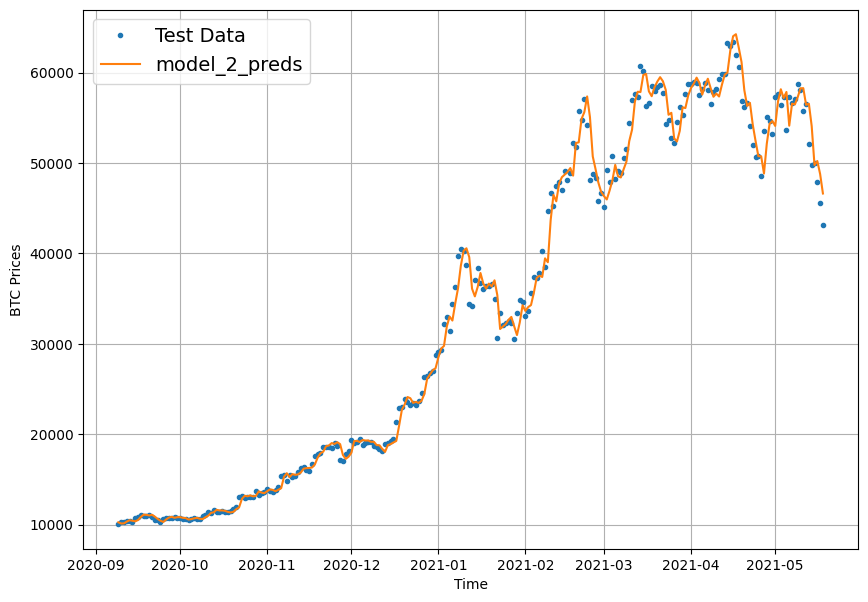

In [58]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for test window offset when plotting
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0],
                 start=offset,
                 label="Test Data")

plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=model_2_preds,
                 start=offset,
                 format="-",
                 label="model_2_preds")

## Model 3: Dense (window = 30, horizon = 7)

In [59]:
WINDOW_SIZE = 30
HORIZON = 7

In [60]:
# Make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [61]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [62]:
tf.random.set_seed(42)

model_3 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: mod

In [63]:
# Evaluate the model on the test data
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 1431.2914


1431.2913818359375

In [64]:
# Load best version of model_3
model_3 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 1222.2456


1222.24560546875

In [65]:
# Make predictions with model_3
model_3_preds = make_preds(model_3,
                           input_data=test_windows)
model_3_preds[:5]

18/18 [==============================] - 0s 3ms/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9324.51 , 9390.107, 9471.294, 9555.049, 9283.923, 9301.105,
        9588.6  ],
       [9034.421, 9019.749, 9059.165, 9243.534, 9205.111, 9117.808,
        9281.525],
       [8899.057, 9012.892, 8901.327, 9081.323, 9266.246, 9141.532,
        9051.926],
       [9031.824, 9229.66 , 9042.652, 9344.577, 9310.857, 9372.988,
        9103.651],
       [8717.789, 9048.535, 8832.827, 9257.21 , 8927.277, 9301.679,
        8952.756]], dtype=float32)>

In [66]:
# Evaluate model_3 results
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': array([  623.1547  ,   403.62836 ,   398.3648  ,   578.5784  ,
          463.40652 ,   549.1121  ,   576.7733  ,   529.4246  ,
          509.49127 ,   566.52594 ,   821.9066  ,   901.5128  ,
          906.27765 ,   947.2325  ,   612.5379  ,   320.25467 ,
          208.46707 ,   259.4566  ,   208.73549 ,   275.26605 ,
          150.83168 ,   197.90256 ,   328.1273  ,   283.66644 ,
          216.68164 ,   101.82673 ,   148.90862 ,    98.689316,
          100.730606,   125.647255,   229.7931  ,   370.76666 ,
          323.2066  ,   295.49225 ,   296.6294  ,   298.4311  ,
          330.1677  ,   240.39851 ,   203.69392 ,   268.0688  ,
          457.28912 ,    87.77288 ,    79.12786 ,    70.10323 ,
          121.93485 ,    93.95759 ,   100.36161 ,   152.12402 ,
           77.843544,   114.74547 ,   151.3093  ,   132.69035 ,
          247.20459 ,   200.83252 ,   242.59334 ,   375.39633 ,
          516.7453  ,   475.60178 ,   502.5244  ,   481.64572 ,
          291.46002 ,   227.04324

## Make our evaluation function work for larger horizons

In [67]:
# Create a function to take in model predictions and truth values and return evaluate metrics
def evaluate_preds(y_true, y_pred):
    # Make sure float32 datatype (for metric calculations)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Calculate various evaluation metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)

    # Account for different sized metrics (if longer horizons, we want to reduce metrics to a single value)
    if mae.ndim > 0:
        mae = tf.reduce_mean(mae)
        mse = tf.reduce_mean(mse)
        rmse = tf.reduce_mean(rmse)
        mape = tf.reduce_mean(mape)
        mase = tf.reduce_mean(mase)

    return {"mae": mae.numpy(),
            "mse": mse.numpy(),
            "rmse": rmse.numpy(),
            "mape": mape.numpy(),
            "mase": mase.numpy()}

In [68]:
# Get model_3 results
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1222.2457,
 'mse': 5260547.0,
 'rmse': 1406.0612,
 'mape': 5.5212913,
 'mase': 2.1749177}

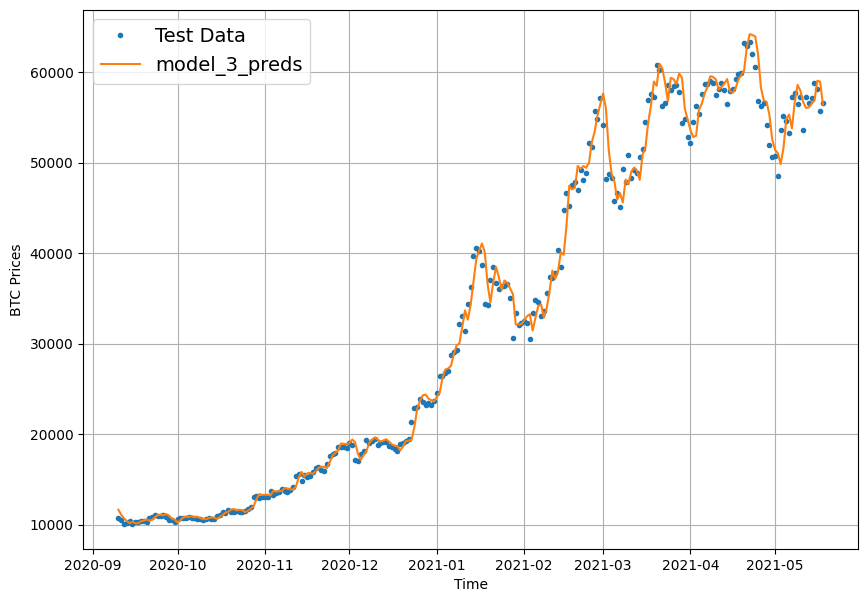

In [69]:
offset = 300
plt.figure(figsize=(10, 7))

plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds[:, 0], start=offset, format="-", label="model_3_preds")

## Which of our models is performing the best so far?

<Axes: >

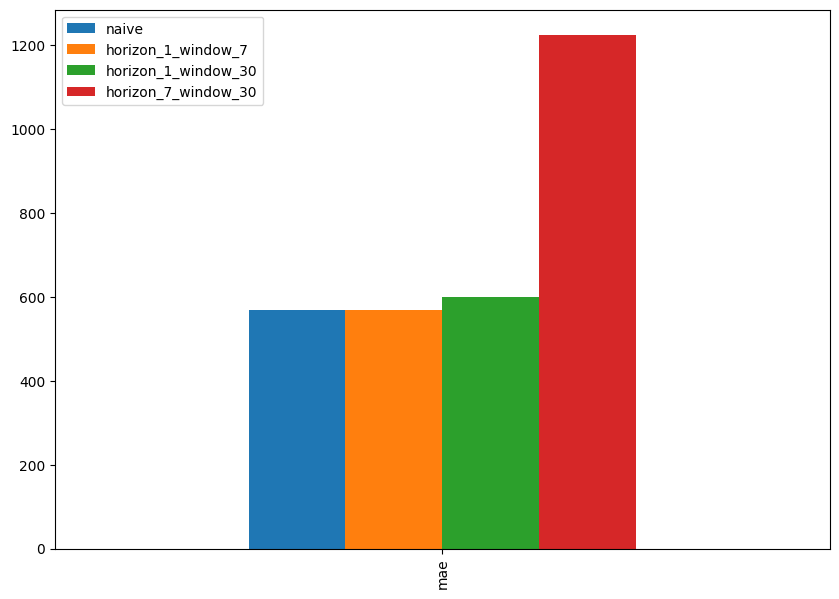

In [70]:
pd.DataFrame({"naive": naive_results["mae"],
              "horizon_1_window_7": model_1_results["mae"],
              "horizon_1_window_30": model_2_results["mae"],
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar")

## Model 4: Conv1D

In [71]:
HORIZON = 1
WINDOW_SIZE = 7     # use previous week worth of data

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [72]:
# Create train/test sets
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(train_labels), len(test_windows), len(test_labels)

(2224, 2224, 556, 556)

To use the Conv1D layer, we need an input shape of: `(batch_size, timesteps, input_dim)`...

However our data isn't in that shape yet

In [73]:
# Check data input shape
train_windows[0].shape


(7,)

In [74]:
# Before we pass ur data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  ])>

In [75]:
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))  # add an extra dimension for 'input_dim'

In [76]:
# Test out our lambda layer
print(f"Original shape: {x.shape}") # WINDOW_SIZE
print(f"Expanded shape: {expand_dims_layer(x).shape}")
print(f"Original values with expanded shape: \n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape: 
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [77]:
tf.random.set_seed(42)

model_4 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    layers.Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="relu"),
    layers.Dense(HORIZON)
], name="model_4_conv1D")

model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_4.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_conv1D\assets


In [78]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [79]:
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 6ms/step - loss: 593.3638


593.36376953125

In [80]:
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 569.4888


569.48876953125

In [81]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

18/18 [==============================] - 0s 3ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8868.796, 8798.177, 8984.719, 8758.027, 8756.802, 8709.601,
       8657.021, 8548.683, 8439.463, 8509.214], dtype=float32)>

In [82]:
# Evaluate predictions
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 569.4888,
 'mse': 1174281.0,
 'rmse': 1083.6425,
 'mape': 2.5493784,
 'mase': 1.000434}

In [83]:
model_1_results

{'mae': 568.09814,
 'mse': 1167905.6,
 'rmse': 1080.6968,
 'mape': 2.541746,
 'mase': 0.9979911}

## Model 5: RNN (LSTM)

In [84]:
tf.random.set_seed(42)

inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
# x = layers.LSTM(128, return_sequences=True)(x)
x = layers.LSTM(128, activation="relu")(x)
# x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_LSTM")

model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

Epoch 1/100
13/18 [====================>.........] - ETA: 0s - loss: 2850.7795INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 5s 200ms/step - loss: 2742.4158 - val_loss: 13000.8242
Epoch 2/100
18/18 [==============================] - ETA: 0s - loss: 1382.0795INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 180ms/step - loss: 1382.0795 - val_loss: 3497.0898
Epoch 3/100
13/18 [====================>.........] - ETA: 0s - loss: 303.6310INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 190ms/step - loss: 304.0416 - val_loss: 1177.6509
Epoch 4/100
14/18 [======================>.......] - ETA: 0s - loss: 216.4971INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 173ms/step - loss: 208.9879 - val_loss: 1056.0963
Epoch 5/100
18/18 [==============================] - 0s 14ms/step - loss: 191.7323 - val_loss: 1074.5083
Epoch 6/100
13/18 [====================>.........] - ETA: 0s - loss: 181.6292INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 173ms/step - loss: 179.0602 - val_loss: 915.2368
Epoch 7/100
18/18 [==============================] - 0s 12ms/step - loss: 162.5121 - val_loss: 1065.2828
Epoch 8/100
18/18 [==============================] - 0s 11ms/step - loss: 180.5210 - val_loss: 1018.0178
Epoch 9/100
18/18 [==============================] - 0s 12ms/step - loss: 178.5730 - val_loss: 1011.3710
Epoch 10/100
18/18 [==============================] - 0s 12ms/step - loss: 176.3792 - val_loss: 990.4308
Epoch 11/100
18/18 [==============================] - 0s 12ms/step - loss: 170.8058 - val_loss: 974.4137
Epoch 12/100
18/18 [==============================] - 0s 13ms/step - loss: 170.8794 - val_loss: 1273.7809
Epoch 13/100
18/18 [==============================] - 0s 13ms/step - loss: 179.1167 - val_loss: 1023.6843
Epoch 14/100
18/18 [==============================] - 0s 12ms/step - loss: 158.0490 - val_loss: 961.8436
Epoch 15/100
18/18 [==============================] - 0s 12ms/ste

INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 172ms/step - loss: 161.6600 - val_loss: 845.7698
Epoch 18/100
18/18 [==============================] - 0s 14ms/step - loss: 156.5588 - val_loss: 939.3846
Epoch 19/100
18/18 [==============================] - 0s 15ms/step - loss: 162.0184 - val_loss: 953.5356
Epoch 20/100
18/18 [==============================] - 0s 12ms/step - loss: 162.9353 - val_loss: 903.5220
Epoch 21/100
18/18 [==============================] - 0s 12ms/step - loss: 158.0222 - val_loss: 906.2930
Epoch 22/100
18/18 [==============================] - 0s 12ms/step - loss: 154.2740 - val_loss: 875.8225
Epoch 23/100
18/18 [==============================] - 0s 12ms/step - loss: 149.7623 - val_loss: 1240.1646
Epoch 24/100
18/18 [==============================] - 0s 13ms/step - loss: 187.6590 - val_loss: 1198.8412
Epoch 25/100
18/18 [==============================] - 0s 13ms/step - loss: 170.2565 - val_loss: 937.5394
Epoch 26/100
18/18 [==============================] - 0s 12ms/ste

INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 5s 271ms/step - loss: 148.5057 - val_loss: 829.9769
Epoch 32/100
18/18 [==============================] - ETA: 0s - loss: 147.9064INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 202ms/step - loss: 147.9064 - val_loss: 822.6866
Epoch 33/100
18/18 [==============================] - 0s 14ms/step - loss: 147.8623 - val_loss: 893.9521
Epoch 34/100
13/18 [====================>.........] - ETA: 0s - loss: 152.7235INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 177ms/step - loss: 146.5648 - val_loss: 796.4238
Epoch 35/100
18/18 [==============================] - 0s 14ms/step - loss: 142.8916 - val_loss: 821.8848
Epoch 36/100
17/18 [===========================>..] - ETA: 0s - loss: 142.8013INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 185ms/step - loss: 143.6833 - val_loss: 783.9639
Epoch 37/100
18/18 [==============================] - 0s 15ms/step - loss: 141.3831 - val_loss: 808.2802
Epoch 38/100
16/18 [=========================>....] - ETA: 0s - loss: 140.0715INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 4s 216ms/step - loss: 139.4888 - val_loss: 765.6465
Epoch 39/100
13/18 [====================>.........] - ETA: 0s - loss: 140.3956INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 5s 287ms/step - loss: 138.7749 - val_loss: 758.5266
Epoch 40/100
18/18 [==============================] - 0s 18ms/step - loss: 137.1765 - val_loss: 777.8831
Epoch 41/100
15/18 [========================>.....] - ETA: 0s - loss: 141.1725INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 202ms/step - loss: 136.1095 - val_loss: 744.3401
Epoch 42/100
18/18 [==============================] - 0s 13ms/step - loss: 134.1407 - val_loss: 748.0323
Epoch 43/100
18/18 [==============================] - 0s 13ms/step - loss: 133.3803 - val_loss: 749.0888
Epoch 44/100
18/18 [==============================] - ETA: 0s - loss: 130.8599INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 198ms/step - loss: 130.8599 - val_loss: 725.9172
Epoch 45/100
17/18 [===========================>..] - ETA: 0s - loss: 130.1632INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 4s 211ms/step - loss: 130.1290 - val_loss: 721.3846
Epoch 46/100
18/18 [==============================] - 0s 14ms/step - loss: 130.4239 - val_loss: 730.2828
Epoch 47/100
18/18 [==============================] - 0s 13ms/step - loss: 129.6581 - val_loss: 730.2118
Epoch 48/100
16/18 [=========================>....] - ETA: 0s - loss: 127.3023INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 182ms/step - loss: 128.5379 - val_loss: 711.0508
Epoch 49/100
17/18 [===========================>..] - ETA: 0s - loss: 127.2846INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 187ms/step - loss: 127.1318 - val_loss: 710.3312
Epoch 50/100
18/18 [==============================] - 0s 13ms/step - loss: 130.1033 - val_loss: 727.9348
Epoch 51/100
18/18 [==============================] - 0s 12ms/step - loss: 130.7505 - val_loss: 817.1117
Epoch 52/100
14/18 [======================>.......] - ETA: 0s - loss: 136.4389INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 180ms/step - loss: 131.1799 - val_loss: 697.9326
Epoch 53/100
18/18 [==============================] - 0s 11ms/step - loss: 126.3746 - val_loss: 708.1590
Epoch 54/100
14/18 [======================>.......] - ETA: 0s - loss: 128.3752INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 188ms/step - loss: 125.6911 - val_loss: 697.7335
Epoch 55/100
18/18 [==============================] - ETA: 0s - loss: 123.9279INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 182ms/step - loss: 123.9279 - val_loss: 670.8152
Epoch 56/100
18/18 [==============================] - 0s 13ms/step - loss: 126.0155 - val_loss: 675.1408
Epoch 57/100
18/18 [==============================] - 0s 12ms/step - loss: 125.3500 - val_loss: 695.0560
Epoch 58/100
13/18 [====================>.........] - ETA: 0s - loss: 123.7928INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 166ms/step - loss: 122.3808 - val_loss: 660.0562
Epoch 59/100
13/18 [====================>.........] - ETA: 0s - loss: 117.7529INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 159ms/step - loss: 120.6814 - val_loss: 656.6420
Epoch 60/100
18/18 [==============================] - 0s 12ms/step - loss: 121.5436 - val_loss: 658.0478
Epoch 61/100
18/18 [==============================] - 0s 12ms/step - loss: 120.8703 - val_loss: 694.1703
Epoch 62/100
18/18 [==============================] - 0s 11ms/step - loss: 123.2980 - val_loss: 710.8133
Epoch 63/100
13/18 [====================>.........] - ETA: 0s - loss: 130.8220INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 186ms/step - loss: 126.1029 - val_loss: 647.5616
Epoch 64/100
18/18 [==============================] - 0s 12ms/step - loss: 118.8747 - val_loss: 659.9130
Epoch 65/100
13/18 [====================>.........] - ETA: 0s - loss: 118.6430INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 160ms/step - loss: 118.9876 - val_loss: 640.8555
Epoch 66/100
18/18 [==============================] - 0s 12ms/step - loss: 118.4476 - val_loss: 653.1764
Epoch 67/100
18/18 [==============================] - 0s 12ms/step - loss: 120.8673 - val_loss: 645.9826
Epoch 68/100
14/18 [======================>.......] - ETA: 0s - loss: 119.2990INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 161ms/step - loss: 118.3372 - val_loss: 632.9413
Epoch 69/100
18/18 [==============================] - 0s 12ms/step - loss: 122.1632 - val_loss: 665.1038
Epoch 70/100
18/18 [==============================] - 0s 12ms/step - loss: 120.1660 - val_loss: 637.2639
Epoch 71/100
18/18 [==============================] - 0s 12ms/step - loss: 117.8398 - val_loss: 671.4788
Epoch 72/100
13/18 [====================>.........] - ETA: 0s - loss: 120.6166INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 163ms/step - loss: 119.9826 - val_loss: 630.2079
Epoch 73/100
13/18 [====================>.........] - ETA: 0s - loss: 116.0467INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 192ms/step - loss: 116.1269 - val_loss: 626.2421
Epoch 74/100
18/18 [==============================] - 0s 11ms/step - loss: 116.6046 - val_loss: 640.6942
Epoch 75/100
18/18 [==============================] - 0s 12ms/step - loss: 116.2414 - val_loss: 658.3654
Epoch 76/100
13/18 [====================>.........] - ETA: 0s - loss: 116.6572INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 170ms/step - loss: 116.1176 - val_loss: 620.4512
Epoch 77/100
18/18 [==============================] - 0s 12ms/step - loss: 116.2333 - val_loss: 696.0074
Epoch 78/100
18/18 [==============================] - 0s 12ms/step - loss: 119.4349 - val_loss: 650.8685
Epoch 79/100
18/18 [==============================] - ETA: 0s - loss: 116.3689INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 164ms/step - loss: 116.3689 - val_loss: 615.0054
Epoch 80/100
18/18 [==============================] - 0s 12ms/step - loss: 114.0820 - val_loss: 620.5338
Epoch 81/100
18/18 [==============================] - 0s 12ms/step - loss: 114.8701 - val_loss: 648.9058
Epoch 82/100
13/18 [====================>.........] - ETA: 0s - loss: 120.8235INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 160ms/step - loss: 117.7767 - val_loss: 610.5456
Epoch 83/100
18/18 [==============================] - 0s 12ms/step - loss: 115.3149 - val_loss: 628.8961
Epoch 84/100
18/18 [==============================] - 0s 12ms/step - loss: 114.9878 - val_loss: 620.9698
Epoch 85/100
18/18 [==============================] - 0s 11ms/step - loss: 115.0886 - val_loss: 675.5970
Epoch 86/100
18/18 [==============================] - 0s 11ms/step - loss: 118.2988 - val_loss: 620.6541
Epoch 87/100
14/18 [======================>.......] - ETA: 0s - loss: 119.0540INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 184ms/step - loss: 114.9606 - val_loss: 604.8514
Epoch 88/100
18/18 [==============================] - 0s 13ms/step - loss: 113.5299 - val_loss: 611.7625
Epoch 89/100
18/18 [==============================] - 0s 11ms/step - loss: 113.0412 - val_loss: 642.5486
Epoch 90/100
18/18 [==============================] - 0s 11ms/step - loss: 119.0688 - val_loss: 633.9553
Epoch 91/100
18/18 [==============================] - 0s 12ms/step - loss: 116.3695 - val_loss: 619.7795
Epoch 92/100
14/18 [======================>.......] - ETA: 0s - loss: 114.7073INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 163ms/step - loss: 113.3965 - val_loss: 601.4265
Epoch 93/100
18/18 [==============================] - 0s 12ms/step - loss: 114.2334 - val_loss: 605.0597
Epoch 94/100
18/18 [==============================] - 0s 11ms/step - loss: 111.8593 - val_loss: 605.5265
Epoch 95/100
13/18 [====================>.........] - ETA: 0s - loss: 111.8327INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 165ms/step - loss: 112.0197 - val_loss: 601.1630
Epoch 96/100
18/18 [==============================] - 0s 12ms/step - loss: 112.7068 - val_loss: 618.4689
Epoch 97/100
18/18 [==============================] - 0s 12ms/step - loss: 112.7384 - val_loss: 614.8752
Epoch 98/100
14/18 [======================>.......] - ETA: 0s - loss: 113.8448INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 163ms/step - loss: 112.1148 - val_loss: 597.1726
Epoch 99/100
18/18 [==============================] - ETA: 0s - loss: 111.1589INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 179ms/step - loss: 111.1589 - val_loss: 595.0884
Epoch 100/100
18/18 [==============================] - 0s 14ms/step - loss: 112.4940 - val_loss: 607.6299


In [85]:
model_5 = tf.keras.models.load_model("model_experiments/model_5_LSTM")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 595.0884


595.08837890625

In [86]:
# Make predictions with our LSTM model
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:5]

18/18 [==============================] - 0s 3ms/step


<tf.Tensor: shape=(5,), dtype=float32, numpy=array([8947.946, 8817.428, 8950.846, 8766.247, 8757.79 ], dtype=float32)>

In [87]:
# Evaluate model 5 predictions
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 595.0884,
 'mse': 1254338.0,
 'rmse': 1119.9723,
 'mape': 2.682773,
 'mase': 1.0454055}

## Make a multivariate time series data

Before we add a feature to our time series, we need to add a feature

In [88]:
# Let's make a multivariate time series
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [89]:
# Let's add the bitcoin halving events to our dataset
block_reward_1 = 50     # 3 jan 2009 - this block reward isn't in our dataset
block_reward_2 = 25     #  Nov 2012
block_reward_3 = 12.5   # 9 Jul 2016
block_reward_4 = 6.25   # 18 May 2020

# Block reward dates
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")

In [90]:
# Create date ranges where specific block_reward values should be
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2421)

In [91]:
# Add in a block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Add in block reward values as a feature to our dataframe
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4


In [92]:
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


In [93]:
bitcoin_prices_block.tail()

,Price,block_reward
Date,,
2021-05-14,49764.132082,6.25
2021-05-15,50032.693137,6.25
2021-05-16,47885.625255,6.25
2021-05-17,45604.615754,6.25
2021-05-18,43144.471291,6.25


<Axes: xlabel='Date'>

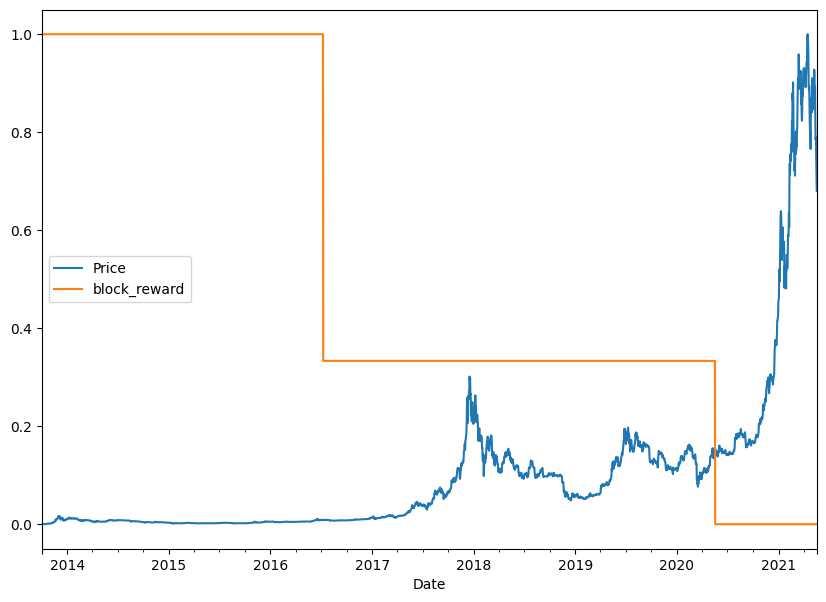

In [94]:
# Plot the block reward vs price over time
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)

scaled_price_block_df.plot(figsize=(10, 7))

## Making a windowed dataset 

In [95]:
# Setup our dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

# Make a copy of the bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE):   # shift values for each step in WINDOW_SIZE
    bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


What we've done is created a way to window our dataset directly from a pandas dataframe

```
[0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
[1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
[2, 3, 4, 5, 6, 7, 8, block_reward] -> [9]
```


In [96]:
# Create X (windows) and y (horizons) features
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [97]:
# Make train and test sets using indexing
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

## Model 6: Dense(multivariate time series)

In [98]:
tf.random.set_seed(42)

model_6 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_6.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=1,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

Epoch 1/100
13/18 [====================>.........] - ETA: 0s - loss: 2156.8345INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 2s 61ms/step - loss: 1710.9232 - val_loss: 2079.2847
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 402.3401 - val_loss: 2141.7673
Epoch 3/100
13/18 [====================>.........] - ETA: 0s - loss: 251.3031INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 44ms/step - loss: 239.7164 - val_loss: 1346.2607
Epoch 4/100
12/18 [===================>..........] - ETA: 0s - loss: 214.3002INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 44ms/step - loss: 202.0353 - val_loss: 1143.1385
Epoch 5/100
13/18 [====================>.........] - ETA: 0s - loss: 201.2581INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 45ms/step - loss: 194.2662 - val_loss: 1078.3264
Epoch 6/100
11/18 [=================>............] - ETA: 0s - loss: 187.9468INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 57ms/step - loss: 190.4086 - val_loss: 1077.2190
Epoch 7/100
16/18 [=========================>....] - ETA: 0s - loss: 190.1515INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 85ms/step - loss: 185.4800 - val_loss: 1008.3583
Epoch 8/100
11/18 [=================>............] - ETA: 0s - loss: 175.5199INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 74ms/step - loss: 176.1918 - val_loss: 954.8066
Epoch 9/100
10/18 [===============>..............] - ETA: 0s - loss: 170.2764INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 61ms/step - loss: 170.9729 - val_loss: 934.4008
Epoch 10/100
12/18 [===================>..........] - ETA: 0s - loss: 160.2673INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 50ms/step - loss: 163.2818 - val_loss: 877.6556
Epoch 11/100
10/18 [===============>..............] - ETA: 0s - loss: 154.9389INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 63ms/step - loss: 154.4877 - val_loss: 838.4783
Epoch 12/100
18/18 [==============================] - 0s 8ms/step - loss: 147.4745 - val_loss: 855.5456
Epoch 13/100
18/18 [==============================] - 0s 7ms/step - loss: 148.7943 - val_loss: 879.8705
Epoch 14/100
13/18 [====================>.........] - ETA: 0s - loss: 139.6139INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 41ms/step - loss: 142.6541 - val_loss: 810.0412
Epoch 15/100
13/18 [====================>.........] - ETA: 0s - loss: 142.7671INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 43ms/step - loss: 144.9226 - val_loss: 782.5422
Epoch 16/100
12/18 [===================>..........] - ETA: 0s - loss: 134.3628INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 43ms/step - loss: 136.9325 - val_loss: 770.7608
Epoch 17/100
12/18 [===================>..........] - ETA: 0s - loss: 139.3787INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 42ms/step - loss: 135.3924 - val_loss: 767.6545
Epoch 18/100
13/18 [====================>.........] - ETA: 0s - loss: 140.4110INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 43ms/step - loss: 133.8368 - val_loss: 727.9118
Epoch 19/100
18/18 [==============================] - 0s 8ms/step - loss: 134.2506 - val_loss: 737.0610
Epoch 20/100
13/18 [====================>.........] - ETA: 0s - loss: 137.2247INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 44ms/step - loss: 131.8619 - val_loss: 725.0811
Epoch 21/100
13/18 [====================>.........] - ETA: 0s - loss: 132.9192INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 43ms/step - loss: 133.6135 - val_loss: 703.8381
Epoch 22/100
18/18 [==============================] - 0s 7ms/step - loss: 130.2187 - val_loss: 743.4111
Epoch 23/100
12/18 [===================>..........] - ETA: 0s - loss: 127.4864INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 43ms/step - loss: 132.2398 - val_loss: 703.3126
Epoch 24/100
11/18 [=================>............] - ETA: 0s - loss: 128.5333INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 44ms/step - loss: 128.5310 - val_loss: 697.6553
Epoch 25/100
13/18 [====================>.........] - ETA: 0s - loss: 132.9259INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 44ms/step - loss: 127.8317 - val_loss: 694.9020
Epoch 26/100
13/18 [====================>.........] - ETA: 0s - loss: 127.4337INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 43ms/step - loss: 129.8147 - val_loss: 673.8715
Epoch 27/100
12/18 [===================>..........] - ETA: 0s - loss: 131.5867INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 43ms/step - loss: 128.2089 - val_loss: 669.6019
Epoch 28/100
18/18 [==============================] - 0s 7ms/step - loss: 124.1888 - val_loss: 677.8519
Epoch 29/100
13/18 [====================>.........] - ETA: 0s - loss: 128.6171INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 43ms/step - loss: 125.5275 - val_loss: 666.4135
Epoch 30/100
13/18 [====================>.........] - ETA: 0s - loss: 125.7527INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 43ms/step - loss: 126.8350 - val_loss: 657.2390
Epoch 31/100
18/18 [==============================] - 0s 8ms/step - loss: 122.5493 - val_loss: 666.6494
Epoch 32/100
13/18 [====================>.........] - ETA: 0s - loss: 124.0655INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 43ms/step - loss: 121.5833 - val_loss: 651.3322
Epoch 33/100
18/18 [==============================] - 0s 7ms/step - loss: 121.2559 - val_loss: 691.7325
Epoch 34/100
13/18 [====================>.........] - ETA: 0s - loss: 128.8152INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 43ms/step - loss: 124.8203 - val_loss: 643.4425
Epoch 35/100
13/18 [====================>.........] - ETA: 0s - loss: 124.0000INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 42ms/step - loss: 119.2584 - val_loss: 640.4694
Epoch 36/100
18/18 [==============================] - 0s 7ms/step - loss: 124.1004 - val_loss: 647.9073
Epoch 37/100
12/18 [===================>..........] - ETA: 0s - loss: 119.5754INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 46ms/step - loss: 120.8153 - val_loss: 635.1850
Epoch 38/100
 9/18 [==============>...............] - ETA: 0s - loss: 121.9071INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 46ms/step - loss: 118.0706 - val_loss: 633.9000
Epoch 39/100
12/18 [===================>..........] - ETA: 0s - loss: 120.6878INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 63ms/step - loss: 119.1556 - val_loss: 630.1025
Epoch 40/100
15/18 [========================>.....] - ETA: 0s - loss: 117.9915INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 45ms/step - loss: 117.7249 - val_loss: 627.9902
Epoch 41/100
18/18 [==============================] - 0s 7ms/step - loss: 117.3246 - val_loss: 628.4875
Epoch 42/100
18/18 [==============================] - 0s 7ms/step - loss: 121.2677 - val_loss: 679.9783
Epoch 43/100
18/18 [==============================] - 0s 7ms/step - loss: 121.4902 - val_loss: 692.9438
Epoch 44/100
14/18 [======================>.......] - ETA: 0s - loss: 119.8455INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 42ms/step - loss: 121.9759 - val_loss: 625.0708
Epoch 45/100
13/18 [====================>.........] - ETA: 0s - loss: 117.2894INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 42ms/step - loss: 117.7373 - val_loss: 622.2214
Epoch 46/100
13/18 [====================>.........] - ETA: 0s - loss: 120.7598INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 43ms/step - loss: 117.9579 - val_loss: 615.8079
Epoch 47/100
18/18 [==============================] - 0s 8ms/step - loss: 116.1548 - val_loss: 705.7612
Epoch 48/100
12/18 [===================>..........] - ETA: 0s - loss: 113.6162INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 43ms/step - loss: 115.6978 - val_loss: 609.2618
Epoch 49/100
18/18 [==============================] - 0s 7ms/step - loss: 116.1861 - val_loss: 664.1862
Epoch 50/100
18/18 [==============================] - 0s 7ms/step - loss: 124.4020 - val_loss: 692.0326
Epoch 51/100
12/18 [===================>..........] - ETA: 0s - loss: 114.8390INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 42ms/step - loss: 116.5248 - val_loss: 603.5216
Epoch 52/100
18/18 [==============================] - 0s 7ms/step - loss: 113.7958 - val_loss: 603.7770
Epoch 53/100
18/18 [==============================] - 0s 7ms/step - loss: 117.2197 - val_loss: 671.7999
Epoch 54/100
18/18 [==============================] - 0s 7ms/step - loss: 124.2820 - val_loss: 754.3058
Epoch 55/100
14/18 [======================>.......] - ETA: 0s - loss: 122.8540INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 42ms/step - loss: 117.8051 - val_loss: 597.2982
Epoch 56/100
18/18 [==============================] - 0s 7ms/step - loss: 112.6302 - val_loss: 791.5394
Epoch 57/100
18/18 [==============================] - 0s 7ms/step - loss: 124.7437 - val_loss: 646.9421
Epoch 58/100
18/18 [==============================] - 0s 7ms/step - loss: 120.7531 - val_loss: 639.4500
Epoch 59/100
18/18 [==============================] - 0s 7ms/step - loss: 114.9094 - val_loss: 613.9244
Epoch 60/100
18/18 [==============================] - 0s 7ms/step - loss: 111.9844 - val_loss: 601.3716
Epoch 61/100
13/18 [====================>.........] - ETA: 0s - loss: 111.5905INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 42ms/step - loss: 112.0150 - val_loss: 591.7726
Epoch 62/100
12/18 [===================>..........] - ETA: 0s - loss: 108.6177INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 42ms/step - loss: 109.7441 - val_loss: 590.2960
Epoch 63/100
18/18 [==============================] - 0s 7ms/step - loss: 111.8670 - val_loss: 608.4525
Epoch 64/100
18/18 [==============================] - 0s 7ms/step - loss: 111.5344 - val_loss: 613.8967
Epoch 65/100
14/18 [======================>.......] - ETA: 0s - loss: 112.1047INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 42ms/step - loss: 111.7845 - val_loss: 587.9515
Epoch 66/100
18/18 [==============================] - 0s 7ms/step - loss: 110.7422 - val_loss: 588.0361
Epoch 67/100
18/18 [==============================] - 0s 7ms/step - loss: 111.5936 - val_loss: 670.8315
Epoch 68/100
18/18 [==============================] - 0s 7ms/step - loss: 117.9802 - val_loss: 750.2679
Epoch 69/100
18/18 [==============================] - 0s 7ms/step - loss: 138.9077 - val_loss: 765.6747
Epoch 70/100
18/18 [==============================] - 0s 7ms/step - loss: 125.4992 - val_loss: 609.3245
Epoch 71/100
18/18 [==============================] - 0s 7ms/step - loss: 116.8173 - val_loss: 606.0820
Epoch 72/100
18/18 [==============================] - 0s 7ms/step - loss: 111.1840 - val_loss: 589.2911
Epoch 73/100
14/18 [======================>.......] - ETA: 0s - loss: 110.4281INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 46ms/step - loss: 109.3236 - val_loss: 581.6669
Epoch 74/100
18/18 [==============================] - 0s 7ms/step - loss: 112.7537 - val_loss: 590.5402
Epoch 75/100
13/18 [====================>.........] - ETA: 0s - loss: 108.4286INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 42ms/step - loss: 110.9331 - val_loss: 579.4667
Epoch 76/100
13/18 [====================>.........] - ETA: 0s - loss: 110.7699INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 43ms/step - loss: 110.1073 - val_loss: 578.5032
Epoch 77/100
13/18 [====================>.........] - ETA: 0s - loss: 112.8417INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 43ms/step - loss: 110.1296 - val_loss: 578.2854
Epoch 78/100
18/18 [==============================] - 0s 7ms/step - loss: 112.6547 - val_loss: 582.6722
Epoch 79/100
18/18 [==============================] - 0s 7ms/step - loss: 110.7261 - val_loss: 600.7756
Epoch 80/100
18/18 [==============================] - 0s 7ms/step - loss: 109.7090 - val_loss: 614.0545
Epoch 81/100
13/18 [====================>.........] - ETA: 0s - loss: 105.0001INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 42ms/step - loss: 108.2927 - val_loss: 577.5120
Epoch 82/100
18/18 [==============================] - 0s 7ms/step - loss: 118.9070 - val_loss: 577.5258
Epoch 83/100
18/18 [==============================] - 0s 10ms/step - loss: 114.4061 - val_loss: 712.9734
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 115.8364 - val_loss: 585.0776
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 109.0947 - val_loss: 589.8093
Epoch 86/100
13/18 [====================>.........] - ETA: 0s - loss: 103.9057INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 43ms/step - loss: 109.1964 - val_loss: 576.4819
Epoch 87/100
18/18 [==============================] - 0s 8ms/step - loss: 108.4999 - val_loss: 595.2950
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 108.4545 - val_loss: 590.3107
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 107.5671 - val_loss: 600.6686
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 107.7979 - val_loss: 600.5041
Epoch 91/100
13/18 [====================>.........] - ETA: 0s - loss: 106.4441INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 43ms/step - loss: 109.9430 - val_loss: 574.0554
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 112.0687 - val_loss: 618.2946
Epoch 93/100
18/18 [==============================] - 0s 7ms/step - loss: 122.6891 - val_loss: 662.5573
Epoch 94/100
18/18 [==============================] - 0s 7ms/step - loss: 115.3432 - val_loss: 586.1508
Epoch 95/100
14/18 [======================>.......] - ETA: 0s - loss: 109.2596INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 66ms/step - loss: 108.6837 - val_loss: 572.4329
Epoch 96/100
18/18 [==============================] - 0s 7ms/step - loss: 118.8926 - val_loss: 699.5552
Epoch 97/100
12/18 [===================>..........] - ETA: 0s - loss: 114.2418INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 43ms/step - loss: 112.4853 - val_loss: 572.3119
Epoch 98/100
18/18 [==============================] - 0s 7ms/step - loss: 108.3533 - val_loss: 574.7733
Epoch 99/100
13/18 [====================>.........] - ETA: 0s - loss: 102.1913INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 42ms/step - loss: 107.6779 - val_loss: 571.6285
Epoch 100/100
18/18 [==============================] - 0s 7ms/step - loss: 112.0785 - val_loss: 654.6772


In [99]:
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 4ms/step - loss: 654.6771


654.6771240234375

In [100]:
model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate")
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 3ms/step - loss: 571.6284


571.62841796875

In [101]:
# Make predictions with multivariate model
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8891.351, 8780.498, 9036.005, 8800.256, 8732.605, 8772.291,
       8698.131, 8514.968, 8487.835, 8531.344], dtype=float32)>

In [102]:
# Evaluate predictions to get evaluate metrics
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 571.6285,
 'mse': 1181735.4,
 'rmse': 1087.0765,
 'mape': 2.5452888,
 'mase': 1.004193}

## Model 7: N-BEATS algorithm

We will be replicating the algorithm in fig 1 from the paper https://arxiv.org/pdf/1905.10437

In [103]:
# Create NBEATS custom layer
class NBeatsBlock(tf.keras.layers.Layer):
    def __init__(self, input_size: int, theta_size: int,
                 horizon: int, n_neurons: int,
                 n_layers: int, **kwargs):  # the **kwargs argument takes care of all the arguments for the parent class (input shape, trainable, name)
        super().__init__(**kwargs)
        self.input_size = input_size
        self.theta_size = theta_size
        self.horizon = horizon
        self.n_neurons = n_neurons
        self.n_layers = n_layers

        # Block contains stack of 4 fully connected layers each has ReLU activation
        self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
        # Output of block is a theta alyer with linear activation
        self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

    def call(self, inputs):
        x = inputs
        for layer in self.hidden:
            x = layer(x)
        theta = self.theta_layer(x)
        # output the backcast and the forecast from theta
        backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
        return backcast, forecast

In [104]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs layers 
tf.random.set_seed(42)
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                      theta_size=WINDOW_SIZE+HORIZON,   # backcast + forecast
                                      horizon=HORIZON,
                                      n_neurons=128,
                                      n_layers=4)


In [105]:
# Create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0)    # input shape to the model has to reflect dense layer in input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]])>

In [106]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# These are the activation outputs of the theta layer (the'll we random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [-0.4861453   0.9601073  -0.00484368 -0.04580529  0.15696838  0.09019704
 -0.07722598]
Forecast: -0.38814443349838257


### Preparing data for the N-BEATS algorithm using tf.data

To make our input data load as fast as possible we're going to be adhearing too the performant data pipelines steps in the tf.data guide

In [107]:
HORIZON = 1 # how far to predict forward
WINDOW_SIZE = 7 # how far to lookback

In [108]:
# Create NBEATS data inputs (NBEATS works with univariate time series)
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [109]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.dropna().head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500
2013-10-10,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483
2013-10-11,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466
2013-10-12,125.92750,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866


In [110]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [111]:
# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

### Setting up hyperparameters for N-BEATS algorithm

The N-BEATS algorithm has a fair few number of parameters

In [112]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 5000 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

### Getting ready for residual connections

The N-BEATS algorithm uses double residual stacking to help train its deep architecture 

In [113]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Substract
subtracted = layers.subtract([tensor_1, tensor_2])

# Add
added = layers.add([tensor_1, tensor_2])

# Get outputs
print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


### Building, compiling and fitting N-BEATS algorithm

We'll do so by going through the following:

1. Setup an instance of the N-BEATS block layer using NBeatsBlock (this'll be the initial block used for the network, the rest will be created as part of stacks)
2. Create an input layer for the N-BEATS stack (we'll be using the Keras Functional API for this)
3. Make the initial backcast and forecasts for the model with the layer created in (1)
4. Use a for loop to create stacks of block layers
5. Use the NBeatsBlock class within the for loop created in (4) to create blocks which return backcasts and block-level forecasts
6. Create the double residual stacking using subtract and add layers
7. Put the model inputs and outputs together using tf.keras.Model()
8. Compile the model with MAE loss (the paper uses multiple losses but we'll use MAE to keep it inline with our other models) and Adam optimizer with default settings as per section 5.2 of N-BEATS paper)
9. Fit the N-BEATS model for 5000 epochs and since it's fitting for so many epochs, we'll use a couple of callbacks:

    * ``tf.keras.callbacks.EarlyStopping()`` - stop the model from training if it doesn't improve validation loss for 200 epochs and restore the best performing weights using restore_best_weights=True (this'll prevent the model from training for loooongggggg period of time without improvement)
    * ``tf.keras.callbacks.ReduceLROnPlateau()`` - if the model's validation loss doesn't improve for 100 epochs, reduce the learning rate by 10x to try and help it make incremental improvements (the smaller the learning rate, the smaller updates a model tries to make)

In [114]:
import time

start_time = time.time()

tf.random.set_seed(42)

# 1. Setup N-BEATS Block laye
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)

residuals, forecast = nbeats_block_layer(stack_input)

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)):   #first stack is already created in (3)
    # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast

    backcast, block_forecast = NBeatsBlock(
        input_size=INPUT_SIZE,
        theta_size=THETA_SIZE,
        horizon=HORIZON,
        n_neurons=N_NEURONS,
        n_layers=N_LAYERS,
        name=f"NBeatsBlock_{i}"
    )(residuals)    # pass in the residuals

    # 6. Create the double residual stacking
    residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
    forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input, outputs=forecast, name="model_7_NBEATS")

# 8. Compile with MAE loss and Adam optimizer
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

#9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset, epochs=N_EPOCHS,
            validation_data=test_dataset, verbose=0,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                        patience=200, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 patience=100,
                                                 verbose=1)])

end_time = time.time()

print(f"Time taken: {end_time - start_time} seconds")


Epoch 853: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 953: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Time taken: 466.24388885498047 seconds


In [115]:
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 84ms/step - loss: 575.3066


575.3065795898438

In [116]:
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

1/1 [==============================] - 3s 3s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8890.715, 8820.24 , 9029.618, 8805.063, 8769.171, 8732.982,
       8693.309, 8552.355, 8477.8  , 8533.942], dtype=float32)>

In [117]:
model_7_results = evaluate_preds(y_true = y_test,
                                 y_pred = model_7_preds)
model_7_results

{'mae': 575.3066,
 'mse': 1191060.2,
 'rmse': 1091.357,
 'mape': 2.6065671,
 'mase': 1.0106543}

In [118]:
model_1_results

{'mae': 568.09814,
 'mse': 1167905.6,
 'rmse': 1080.6968,
 'mape': 2.541746,
 'mase': 0.9979911}

In [119]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

### Plotting the N-BEATS architecture we've created

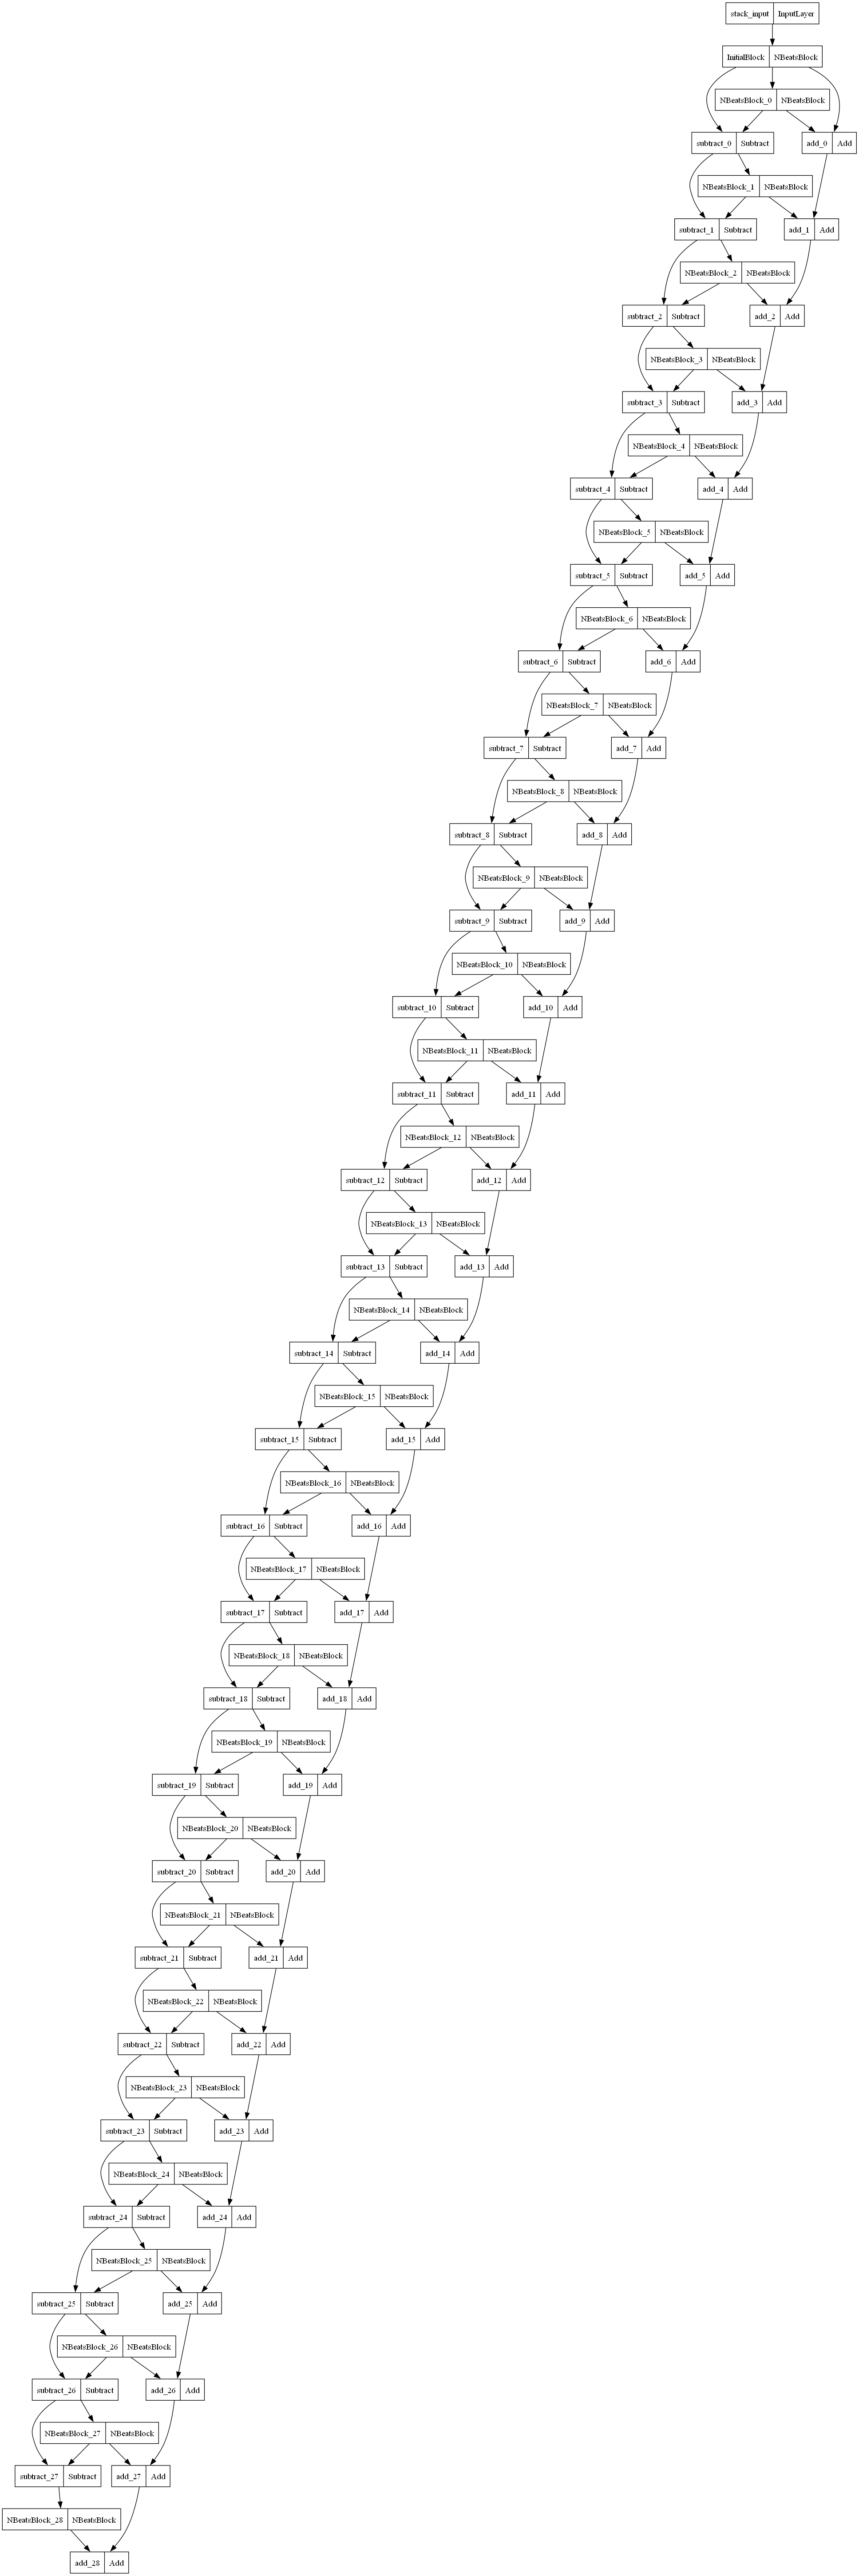

In [120]:
# Plot the N-BEATS model and compare and inspect the architecture
from tensorflow.keras.utils import plot_model
plot_model(model_7)

## Model 8: Creating an ensemble (stacking different models together)

An ensemble leverages the wisdom of the crowd effect.

It combones many different models to predict a common goal

In [121]:
HORIZON, WINDOW_SIZE

(1, 7)

### Construct and fitting an ensemble of models (using different loss functions)

In [122]:
def get_ensemble_models(horizon=HORIZON, 
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10, 
                        num_epochs=100, 
                        loss_fns=["mae", "mse", "mape"]):
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned:
  10 * len(["mae", "mse", "mape"]).
  """
  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
        # Initialize layers with normal (Gaussian) distribution so we can use the models for prediction
        # interval estimation later: https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeNormal
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"), 
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(HORIZON)                                 
      ])

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])
      
      # Fit model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                # Add callbacks to prevent training from going/stalling for too long
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])
      
      # Append fitted model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models # return list of trained models

In [123]:
import time

start_time = time.time()

ensemble_models = get_ensemble_models(num_iter=10,
num_epochs=1000)

end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 421: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 882: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 982: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 263: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 363: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 185: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 653: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 753: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mae for 1000 epochs, model number: 1

Epoch 111: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing 

### Make predictions with our ensemble model

In [124]:
# Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
    ensemble_preds = []
    for model in ensemble_models:
        preds = model.predict(data)
        ensemble_preds.append(preds)
    return tf.constant(tf.squeeze(ensemble_preds))

In [125]:
# Create a list of ensemble predictions
start_time = time.time()

ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)
ensemble_models

end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

1/1 [==============================] - 0s 68ms/step


1/1 [==============================] - 0s 74ms/step


1/1 [==============================] - 0s 68ms/step
Time taken: 2.416964292526245 seconds


In [126]:
ensemble_preds

<tf.Tensor: shape=(30, 556), dtype=float32, numpy=
array([[ 8849.051,  8766.952,  9019.701, ..., 49973.4  , 48286.52 ,
        45786.113],
       [ 8781.435,  8770.476,  9087.645, ..., 49776.336, 48248.793,
        45279.25 ],
       [ 8807.647,  8805.951,  9084.672, ..., 49809.15 , 47615.656,
        45144.137],
       ...,
       [ 8728.774,  8778.683,  9064.341, ..., 49890.93 , 47371.547,
        45319.535],
       [ 9156.691,  9166.771,  9518.496, ..., 53087.246, 51655.863,
        48537.926],
       [ 8727.557,  8738.61 ,  9067.471, ..., 49977.316, 48334.434,
        45982.383]], dtype=float32)>

In [127]:
ensemble_mean = tf.reduce_mean(ensemble_preds, axis=0)
ensemble_mean[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8809.956 , 8796.0625, 9072.47  , 8736.181 , 8760.327 , 8741.418 ,
       8663.912 , 8505.327 , 8468.333 , 8536.038 ], dtype=float32)>

In [128]:
ensemble_median = np.median(ensemble_preds, axis=0)
ensemble_median[:10]

array([8789.886, 8788.229, 9062.365, 8719.805, 8750.114, 8734.559,
       8651.264, 8502.035, 8461.404, 8530.773], dtype=float32)

In [129]:
# Evaluate ensemble model predictions
ensemble_results = evaluate_preds(y_true=y_test, y_pred=ensemble_mean)

ensemble_results

{'mae': 566.81964,
 'mse': 1140351.5,
 'rmse': 1067.8724,
 'mape': 2.5623734,
 'mase': 0.9957451}

In [130]:
# Evaluate ensemble model predictions
ensemble_results = evaluate_preds(y_true=y_test, y_pred=ensemble_median)

ensemble_results

{'mae': 565.34827,
 'mse': 1133002.2,
 'rmse': 1064.4258,
 'mape': 2.5507174,
 'mase': 0.9931603}

### Plotting the prediction intervals (uncertainty estimates) of our ensemble

So far we've been making point predictions with our models.

Eg. horizon = 1, our model predicts tomorrow's price of Bitcoin will be $50,000 USD

Wouldn't it be helpful if we knew a range of where that prediction came from?

Instead of 50k USD on the dot, how about 48k to 52k USD?

One way to get the 95% confidence prediction intervals for a deep learning model is the bootstrap methd:
1. Take the predcitons from a number of randomly initialized models (we've got this thanks to our ensemble models)
2. Measure the standard deviation of the predictins
3. Multiply the standard deviation by 1.96 (assuming the distribution is Gaussian/Normal, 95% of observations fall within 1.96 standard deviations of the mean)
4. To the get the prediction interval upper and lower bounds, add and substract the value obtained in (3) to the mean/median of the predictions made in (1)




In [131]:
# Find the upper and lower bounds of ensemble predictions
def get_upper_lower(preds):
    std = tf.math.reduce_std(preds, axis=0)

    interval = 1.96 * std

    preds_mean = tf.reduce_mean(preds, axis=0)
    lower, upper = preds_mean - interval, preds_mean + interval

    return lower, upper

In [132]:
# Get upper and lower bound
lower, upper = get_upper_lower(preds=ensemble_preds)

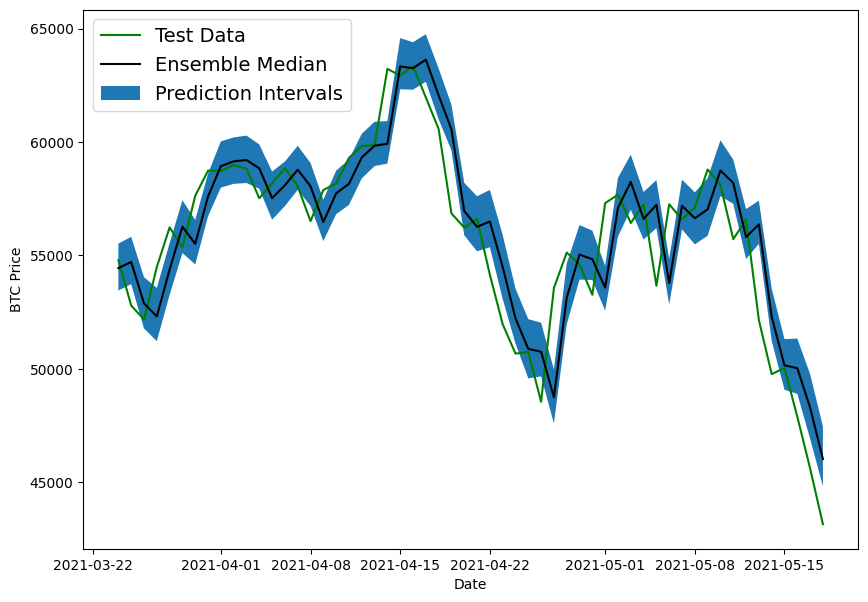

In [133]:
# Get the median/mean
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the predictions intervals (where the predictions fall between)
offset=500
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.fill_between(X_test.index[offset:],
                (lower)[offset:],
                (upper)[offset:], label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14)

Aside: two types of uncertainty (coconut and subway)
Inheritly, you know you cannot predict the future.

That doesn't mean trying to isn't valuable.

For many things, future predictions are helpful. Such as knowing the bus you're trying to catch to the library leaves at 10:08am. The time 10:08am is a point prediction, if the bus left at a random time every day, how helpful would it be?

Just like saying the price of Bitcoin tomorrow will be 50,000USD is a point prediction.

However, as we've discussed knowing a prediction interval or uncertainty estimate can be as helpful or even more helpful than a point prediction itself.

Uncertainty estimates seek out to qualitatively and quantitatively answer the questions:

What can my model know? (with perfect data, what's possible to learn?)
What doesn't my model know? (what can a model never predict?)
There are two types of uncertainty in machine learning you should be aware of:

Aleatoric uncertainty - this type of uncertainty cannot be reduced, it is also referred to as "data" or "subway" uncertainty.

Let's say your train is scheduled to arrive at 10:08am but very rarely does it arrive at exactly 10:08am. You know it's usually a minute or two either side and perhaps up to 10-minutes late if traffic is bad. Even with all the data you could imagine, this level of uncertainty is still going to be present (much of it being noise).
When we measured prediction intervals, we were measuring a form of subway uncertainty for Bitcoin price predictions (a little either side of the point prediction).
Epistemic uncertainty - this type of uncertainty can be reduced, it is also referred to as "model" or "coconut" uncertainty, it is very hard to calculate.

The analogy for coconut uncertainty involves whether or not you'd get hit on the head by a coconut when going to a beach.
If you were at a beach with coconuts trees, as you could imagine, this would be very hard to calculate. How often does a coconut fall of a tree? Where are you standing?
But you could reduce this uncertainty to zero by going to a beach without coconuts (collect more data about your situation).
Model uncertainty can be reduced by collecting more data samples/building a model to capture different parameters about the data you're modelling.
The lines between these are blurred (one type of uncertainty can change forms into the other) and they can be confusing at first but are important to keep in mind for any kind of time series prediction.

If you ignore the uncertanties, are you really going to get a reliable prediction?

Perhaps another example might help.

## Model 9: Train a model on the full historical data to make predictions into the future

In [134]:
bitcoin_prices_windowed.head()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [135]:
bitcoin_prices_windowed.tail()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2021-05-14,49764.132082,6.25,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672,56583.849879
2021-05-15,50032.693137,6.25,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672
2021-05-16,47885.625255,6.25,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679
2021-05-17,45604.615754,6.25,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426
2021-05-18,43144.471291,6.25,45604.615754,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651


In [136]:
# Train model on entire data to make predictions for the next day
X_all = bitcoin_prices_windowed.dropna().drop(["Price", "block_reward"], axis=1).to_numpy()

# Get labels
y_all = bitcoin_prices_windowed.dropna()["Price"]

len(X_all), len(y_all)

(2780, 2780)

In [139]:
X_all[:5], y_all[:5]

(array([[121.795  , 120.65533, 121.33866, 118.67466, 108.58483, 125.455  ,
         123.65499],
        [123.033  , 121.795  , 120.65533, 121.33866, 118.67466, 108.58483,
         125.455  ],
        [124.049  , 123.033  , 121.795  , 120.65533, 121.33866, 118.67466,
         108.58483],
        [125.96116, 124.049  , 123.033  , 121.795  , 120.65533, 121.33866,
         118.67466],
        [125.27966, 125.96116, 124.049  , 123.033  , 121.795  , 120.65533,
         121.33866]]),
 Date
 2013-10-08    123.03300
 2013-10-09    124.04900
 2013-10-10    125.96116
 2013-10-11    125.27966
 2013-10-12    125.92750
 Name: Price, dtype: float64)

In [140]:
# Turn data into efficient running tensors

features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# Combine features and labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# Batch and prefetch for optimzal performace
BATCH_SIZE = 1024
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [142]:
tf.random.set_seed(42)

model_9 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_9_future_model")

model_9.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam())

model_9.fit(dataset_all,
            epochs=100,
            verbose=0,
            )



### Make predictions into future

In [143]:
# How many timesteps to predict into the future?
INTO_FUTURE = 14

To make predictions into the future we want a function which:
1. Takes as input:
     * a list of values (Bitcoin historical data)
     * a trained model (such as `model_9`)
     * a window into the future to predict (our `INTO_FUTURE` variable)
     * the window size a model was trained on (`WINDOW_SIZE`) - the model can only predict on the same kind of data it was trained on
2. Creates an empty list for future forecasts this will be returned at the end of the end, when it's full of predictions and extracts the last `WINDOW_SIZE` values from the input values 
3. Loop `INTO_FUTURE` times making a prediction on `WINDOW_SIZE` sequences which update to remove the first value and append the latest prediction


In [148]:
# 1. Create function to make predictions into the future
def make_future_forecasts(values, model, into_future, window_size=WINDOW_SIZE) -> list:
    """
    Make future forecast into_future steps after values ends.

    Returns future forecasts as a list floats.
    """
    # 2. Create an empty list for future forecasts/prepare data to forecast on
    future_forecast = []
    last_window = values[-WINDOW_SIZE:]

    # 3. Make INTO_FUTURE number of predictions, altering the data which gets predicted on each
    for _ in range(INTO_FUTURE):
        # Predict on the last window then append it again and again
        future_pred = model.predict(tf.expand_dims(last_window, axis=0))
        print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

        # Append predictions to future forecast
        future_forecast.append(tf.squeeze(future_pred).numpy())

        # Update last window with new pred and yet WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
        last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
    return future_forecast


In [149]:
# Make forecast into the future
future_forecast = make_future_forecasts(values=y_all,
                                        model=model_9,
                                        into_future=INTO_FUTURE,
                                        window_size=WINDOW_SIZE)

1/1 [==============================] - 0s 113ms/step
Predicting on: 
 Date
2021-05-12    56573.555472
2021-05-13    52147.821187
2021-05-14    49764.132082
2021-05-15    50032.693137
2021-05-16    47885.625255
2021-05-17    45604.615754
2021-05-18    43144.471291
Name: Price, dtype: float64 -> Prediction: 55685.1328125

1/1 [==============================] - 0s 45ms/step
Predicting on: 
 [52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 55685.1328125 ] -> Prediction: 50189.78515625

1/1 [==============================] - 0s 52ms/step
Predicting on: 
 [49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 55685.1328125  50189.78515625] -> Prediction: 51289.47265625

1/1 [==============================] - 0s 55ms/step
Predicting on: 
 [50032.69313676 47885.62525472 45604.61575361 43144.47129086
 55685.1328125  50189.78515625 51289.47265625] -> Prediction: 48555.26171875

1/1 [==============================] - 0s 37ms/step
Pr

In [150]:
bitcoin_prices_windowed.tail()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2021-05-14,49764.132082,6.25,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672,56583.849879
2021-05-15,50032.693137,6.25,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672
2021-05-16,47885.625255,6.25,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679
2021-05-17,45604.615754,6.25,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426
2021-05-18,43144.471291,6.25,45604.615754,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651


## Plot future forecast

In [152]:
future_forecast

[55685.133,
 50189.785,
 51289.473,
 48555.26,
 46644.65,
 46344.01,
 47710.363,
 54440.176,
 49990.523,
 51128.67,
 47282.504,
 47031.95,
 47814.19,
 50214.684]

In [153]:
def get_future_dates(start_date, into_future, offset=1):
    """
    Returns array of datatime values ranging from start_data to start_data+into_future
    """
    start_date = start_date + np.timedelta64(offset, "D")   # specify start data, "D" stands for day, 
    end_date = start_date + np.timedelta64(into_future, "D")    # specify end date
    return np.arange(start_date, end_date, dtype="datetime64[D]")   # return a date range between start and end date

In [154]:
# Last timestep of timesteps (currently np.datetime64 format)
last_timestep = bitcoin_prices.index[-1]
last_timestep

Timestamp('2021-05-18 00:00:00')

In [156]:
type(last_timestep)

pandas._libs.tslibs.timestamps.Timestamp

In [157]:
# Get next two week of timesteps
next_time_steps = get_future_dates(start_date=last_timestep,
                                   into_future=INTO_FUTURE)
next_time_steps

array(['2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
       '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26',
       '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
       '2021-05-31', '2021-06-01'], dtype='datetime64[D]')

In [159]:
# Insert last timestep/final price into next time steps and future forecast so the plt dosen't look jankey
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, btc_price[-1])
next_time_steps, future_forecast

(array(['2021-05-18', '2021-05-19', '2021-05-20', '2021-05-21',
        '2021-05-22', '2021-05-23', '2021-05-24', '2021-05-25',
        '2021-05-26', '2021-05-27', '2021-05-28', '2021-05-29',
        '2021-05-30', '2021-05-31', '2021-06-01'], dtype='datetime64[D]'),
 array([43144.473, 55685.133, 50189.785, 51289.473, 48555.26 , 46644.65 ,
        46344.01 , 47710.363, 54440.176, 49990.523, 51128.67 , 47282.504,
        47031.95 , 47814.19 , 50214.684], dtype=float32))

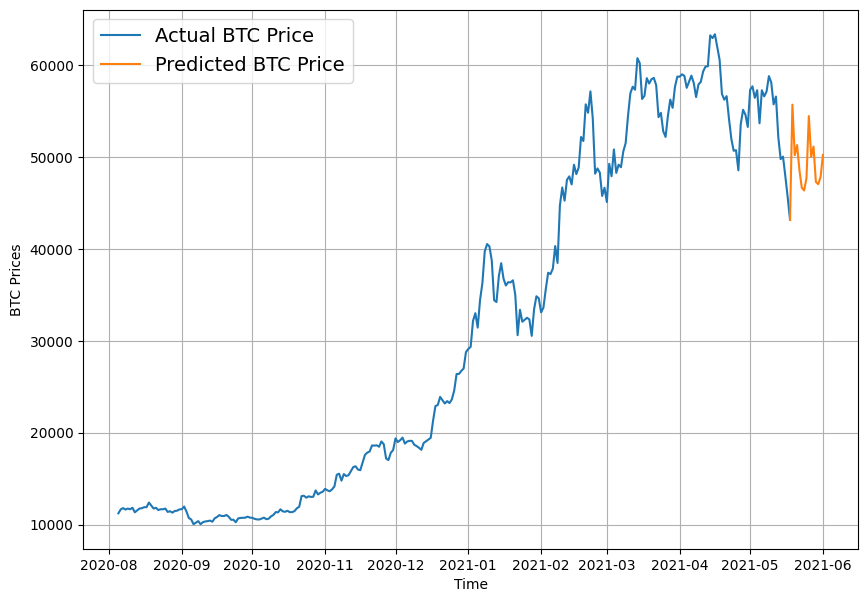

In [160]:
# Plot future predictins of Bitcoin
plt.figure(figsize=(10, 7))
plot_time_series(bitcoin_prices.index, btc_price, start=2500, format="-", label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted BTC Price")

## Model 10: Why forecasting is BS (the turkey problem)

In [161]:
# Let's introduce our turkey problem to our BTC data (price of BTC falls 100x in one day)
btc_price_turkey = btc_price.copy()
btc_price_turkey[-1] = btc_price_turkey[-1] / 100

In [162]:
# Manufacture an extra price on the end (to showcast our Turkey problem)
btc_price_turkey[-10:]

[58788.2096789273,
 58102.1914262342,
 55715.5466512869,
 56573.5554719043,
 52147.8211869823,
 49764.1320815975,
 50032.6931367648,
 47885.6252547166,
 45604.6157536131,
 431.44471290860304]

In [164]:
# Get the timesteps for the turkey problem
btc_timesteps_turkey = np.array(bitcoin_prices.index)
btc_timesteps_turkey[-10:]

array(['2021-05-09T00:00:00.000000000', '2021-05-10T00:00:00.000000000',
       '2021-05-11T00:00:00.000000000', '2021-05-12T00:00:00.000000000',
       '2021-05-13T00:00:00.000000000', '2021-05-14T00:00:00.000000000',
       '2021-05-15T00:00:00.000000000', '2021-05-16T00:00:00.000000000',
       '2021-05-17T00:00:00.000000000', '2021-05-18T00:00:00.000000000'],
      dtype='datetime64[ns]')

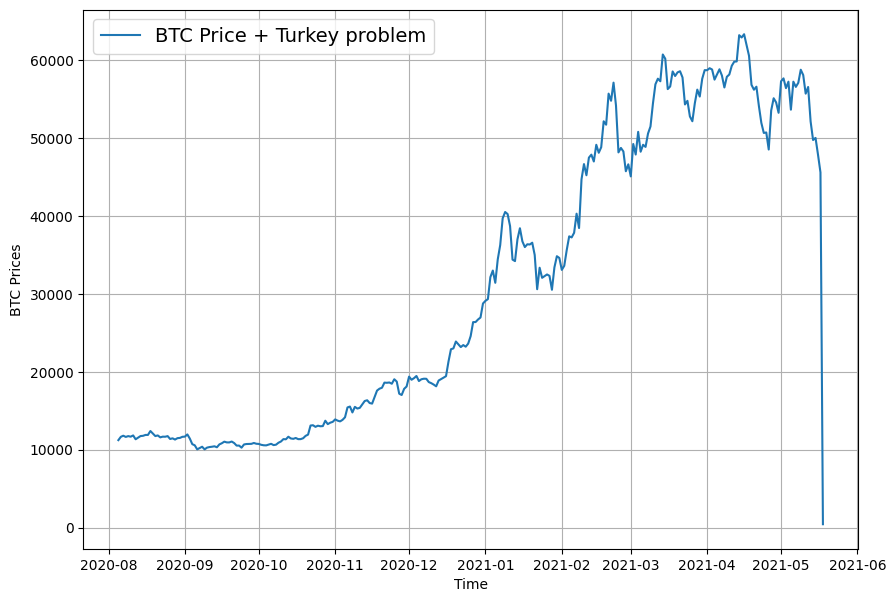

In [167]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=btc_timesteps_turkey,
                 values=btc_price_turkey,
                 format="-",
                 label="BTC Price + Turkey problem",
                 start=2500)

In [168]:
WINDOW_SIZE = 7
HORIZON = 1

In [170]:
# Create train and test sets for the turkey problem data
full_windows, full_labels = make_windows(np.array(btc_price_turkey), window_size=WINDOW_SIZE, horizon=HORIZON)

X_train, X_test, y_train, y_test = make_train_test_splits(full_windows, full_labels)
len(X_train), len(X_test), len(y_train), len(y_test)

(2224, 556, 2224, 556)

In [171]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1024      
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
_________________________________________________________________


### Build a turkey model (model to predict on turkey data)

In [174]:
# Clone model 1 architecture for turkey model and fit the turkey model on the turkey data
turkey_model = tf.keras.models.clone_model(model_1)
turkey_model.__name = "model_10_turkey_model"
turkey_model.compile(loss="mae",
                     optimizer=tf.keras.optimizers.Adam())

turkey_model.fit(X_train, y_train,
                 epochs=100,
                 verbose=0,
                 batch_size=128,
                 validation_data=(X_test, y_test),
                 callbacks=[create_model_checkpoint(turkey_model.name)])


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


In [175]:
# Evaluate model on test data
turkey_model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 4ms/step - loss: 655.9714


655.971435546875

In [176]:
# Load best performing turkey model and evaluate on test data
turkey_model = tf.keras.models.load_model("model_experiments/model_1_dense")
turkey_model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 6ms/step - loss: 645.7886


645.7886352539062

In [179]:
# Make predictions with turkey model
turkey_preds = make_preds(turkey_model, X_test)
turkey_preds[:10]

18/18 [==============================] - 0s 4ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8847.724, 8775.059, 9069.408, 8807.263, 8712.959, 8747.257,
       8693.655, 8522.056, 8458.799, 8543.403], dtype=float32)>

In [180]:
# Evaluate turkey preds
turkey_results = evaluate_preds(y_true=y_test,
                                y_pred=turkey_preds)

turkey_results

{'mae': 17129.834,
 'mse': 614411600.0,
 'rmse': 23713.838,
 'mape': 121.36609,
 'mase': 26.508476}

In [181]:
model_1_results

{'mae': 568.09814,
 'mse': 1167905.6,
 'rmse': 1080.6968,
 'mape': 2.541746,
 'mase': 0.9979911}

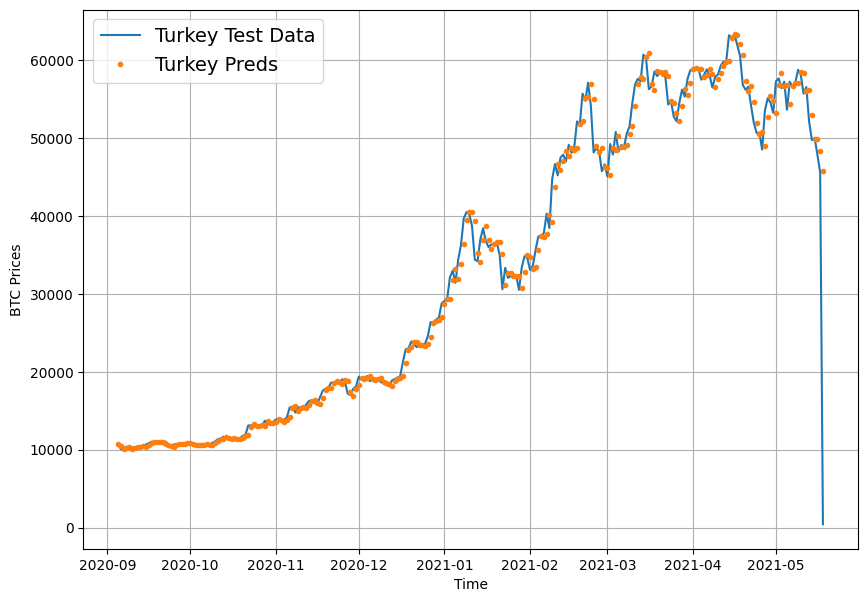

In [182]:
plt.figure(figsize=(10, 7))
offset=300
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=btc_price_turkey[-len(y_test):],
                 format="-",
                 label="Turkey Test Data", start=offset)
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=turkey_preds,
                 label="Turkey Preds",
                 start=offset);

### Compare models

In [184]:
# Compare different model results (w = window, h = horizon)
model_results = pd.DataFrame({"naive_model": naive_results,
                             "model_1_dense_w2_h1": model_1_results,
                             "model_2_dense_w30_h1": model_2_results,
                             "model_3_dense_w30_h7": model_3_results,
                             "model_4_CONV1D": model_4_results,
                             "model_5_LSTM": model_5_results,
                             "model_6_multivariate": model_6_results,
                             "model_7_NBEATS": model_7_results,
                             "model_8_ensemble": ensemble_results,
                             "model_10_turkey": turkey_results,}).T

model_results.head(10)

,mae,mse,rmse,mape,mase
naive_model,567.980225,1.147547e+06,1071.236206,2.516525,0.999570
model_1_dense_w2_h1,568.098145,1.167906e+06,1080.696777,2.541746,0.997991
model_2_dense_w30_h1,599.332336,1.228500e+06,1108.377197,2.745014,1.047639
model_3_dense_w30_h7,1222.245728,5.260547e+06,1406.061157,5.521291,2.174918
model_4_CONV1D,569.488770,1.174281e+06,1083.642456,2.549378,1.000434
model_5_LSTM,595.088379,1.254338e+06,1119.972290,2.682773,1.045406
model_6_multivariate,571.628479,1.181735e+06,1087.076538,2.545289,1.004193
model_7_NBEATS,575.306580,1.191060e+06,1091.357056,2.606567,1.010654
model_8_ensemble,565.348267,1.133002e+06,1064.425781,2.550717,0.993160
model_10_turkey,17129.833984,6.144116e+08,23713.837891,121.366089,26.508476


<Axes: >

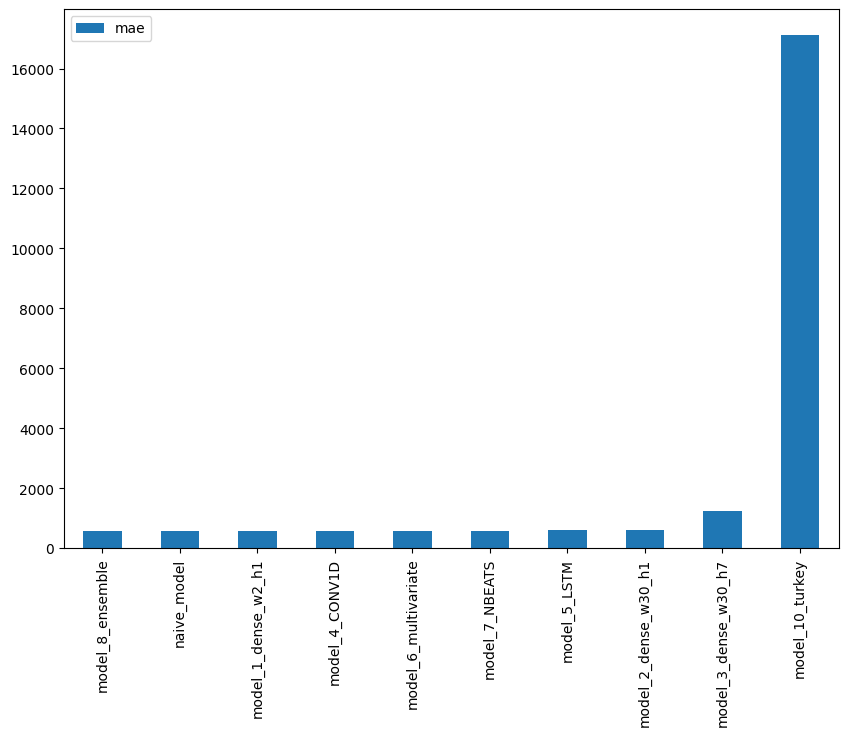

In [187]:
# Sort model results by MAE and plot them
model_results[["mae"]].sort_values(by="mae").plot(figsize=(10, 7), kind="bar")